In [1]:
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2010-12-31 00:00:00
4017


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)

/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR


## create CMF model BMI object

In [6]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
print(CMF_engine)
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date, dt=86400)


/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/cama-flood_bmi/src/libcama.so


## create DFM model BMI object

In [7]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date, dt=86400.)

/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/DFM


## intitialize DFM model

In [8]:
# initialize DFM first to expose model coordinates via BMI
DFM_bmi.initialize()

## couple grids based on CMF inpmat file

In [9]:
# couple grids
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## couple CMF to DFM based on 1d DFM indices

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

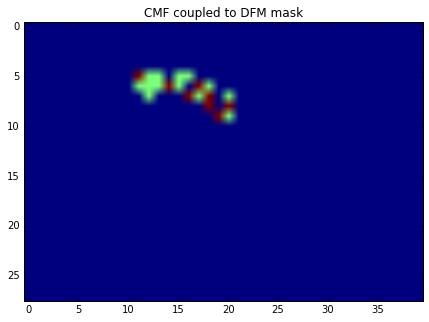

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# get coupled dictionaries
CMF_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(CMF_bmi.coupled_mask, vmin=0, vmax=2)
b.set_title('CMF coupled to DFM mask')

note there is a difference in DFM nodes and DFM coupled nodes as some are in unit catchments that are ignored by CMF. The runoff from PCR is however mass-conservative in the CMF runoff input.

In [11]:
len(DFM_bmi.model_1d_coords), len(DFM_bmi.coupled_idx)

(1428, 1425)

## initialize CMF and PCR models

In [12]:
# initialize CMF model after nextxy had been adapted
CMF_bmi.initialize()
# initialize model after ldd has been modified
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-07 12:34:41.425808
2018-03-07 12:34:41,432 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-07 12:34:41.425808
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-07T12:34:41.425808.log
2018-03-07 12:34:41,434 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-07T12:34:41.425808.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-07 12:34:41,435 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this

## define exchange of values in update states function

In [13]:
def get_CMF_delta_vol():
    # coupled 2d mask
    mask = (CMF_bmi.coupled_mask > 0).astype(float)
    # total Q inflow 2D for coupled cells
    q_in = (CMF_bmi.get_var('rivinf') + CMF_bmi.get_var('fldinf')) * mask # [m3/s]
    # total CMF converted runoff inflow 2D for coupled cells
    runoff = CMF_bmi.get_var('runoff') * mask # [m3/s]
    # take Qin + runoff in most upstream coupled cells, only runoff for other cells
    tot_flux = np.where(CMF_bmi.coupled_mask == 2, q_in + runoff, runoff)
    # convert flux to volume per day
    delta_vol = tot_flux * CMF_bmi.options['dt'] # [m3/day]
    return delta_vol 

def set_CMF_forcing():
    "coupling runoff between CMFan PCR model"
    runoff = PCR_bmi.get_var('landSurfaceRunoff') # [m/day]
    runoff = np.where(np.isnan(runoff), 0, runoff)
    # note that runoff in (roffin) should be used to set PCR runoff. 
    CMF_bmi.set_var("roffin", runoff) # [m/dtin] = [m/d]

DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
CMFidx = CMF_bmi.coupled_idx
CMFfrac = CMF_bmi.coupled_area_frac

def set_DFM_forcing():
    CMF_delta_vol = get_CMF_delta_vol() # 2d array [m3/day]
    DFM_depth_conservative = CMF_delta_vol[CMFidx] * CMFfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
        

## run coupled CMF - DFM model

In [14]:
# run coupled model for 2 timesteps
# for i in range(2):
# run for numer of timesteps specified in set-file
tStart = datetime.now()
for i in range(timeSteps):
    PCR_bmi.update()
    set_CMF_forcing()
    CMF_bmi.update()
    set_DFM_forcing()
    DFM_bmi.update()
tEnd = datetime.now()

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-07 12:34:56,856 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-07 12:34:57,151 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-07 12:34:59,476 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-07 12:34:59,520 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-03-07 12:35:00,605 coupling_PCR_FM.model_functions_v2 INFO DFM -> 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
2018-03-07 12:35:17,902 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-09
2018-03-07 12:35:17,909 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09
INFO: pcrglobwb.update(): updating model to time 2000-01-09
2018-03-07 12:35:18,380 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-03-07 12:35:19,711 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-10 00:00:00, timestep 86400.0
2018-03-07 12:35:20,060 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
2018-03-07 12:35:40,021 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
2018-03-07 12:35:41,315 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-17
2018-03-07 12:35:41,321 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
INFO: pcrglobwb.update(): updating model to time 2000-01-17
2018-03-07 12:35:41,859 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-03-07 12:35:43,096 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
2018-03-07 12:36:10,840 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
2018-03-07 12:36:10,918 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
2018-03-07 12:36:13,029 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-25
2018-03-07 12:36:13,033 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-25
INFO: pcrglobwb.update(): updating model to time 2000-01-25
2018-03-07 12:36:13,502 pcrglo

2018-03-07 12:36:47,523 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
INFO: pcrglobwb.update(): updating model to time 2000-02-01
2018-03-07 12:36:48,024 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
2018-03-07 12:36:49,519 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
2018-03-07 12:36:49,615 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-03-07 12:36:52,200 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
2018-03-07 12:37:27,272 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-09
2018-03-07 12:37:27,280 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
INFO: pcrglobwb.update(): updating model to time 2000-02-09
2018-03-07 12:37:27,796 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
2018-03-07 12:37:29,032 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-10 00:00:00, timestep 86400.0
2018-03-07 12:37:29,287 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
2018-03-07 12:38:06,117 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
2018-03-07 12:38:10,013 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-17
2018-03-07 12:38:10,016 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
INFO: pcrglobwb.update(): updating model to time 2000-02-17
2018-03-07 12:38:10,622 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48
2018-03-07 12:38:11,896 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
2018-03-07 12:38:40,761 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
2018-03-07 12:38:40,856 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
2018-03-07 12:38:43,292 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-25
2018-03-07 12:38:43,300 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-25
INFO: pcrglobwb.update(): updating model to time 2000-02-25
2018-03-07 12:38:43,806 pcrglo

2018-03-07 12:39:14,085 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
INFO: pcrglobwb.update(): updating model to time 2000-03-03
2018-03-07 12:39:14,526 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
2018-03-07 12:39:15,709 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
2018-03-07 12:39:15,787 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
2018-03-07 12:39:18,521 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
2018-03-07 12:39:47,577 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-07 12:39:47,582 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-07 12:39:48,104 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-07 12:39:49,362 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
2018-03-07 12:39:49,420 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
2018-03-07 12:40:20,068 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
2018-03-07 12:40:23,229 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-19
2018-03-07 12:40:23,234 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-19
INFO: pcrglobwb.update(): updating model to time 2000-03-19
2018-03-07 12:40:23,757 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79
2018-03-07 12:40:24,976 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
2018-03-07 12:41:01,173 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
2018-03-07 12:41:01,514 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
2018-03-07 12:41:04,107 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-27
2018-03-07 12:41:04,110 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-27
INFO: pcrglobwb.update(): updating model to time 2000-03-27
2018-03-07 12:41:04,656 pcrglo

2018-03-07 12:41:33,233 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-03
INFO: pcrglobwb.update(): updating model to time 2000-04-03
2018-03-07 12:41:33,764 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
2018-03-07 12:41:34,969 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
2018-03-07 12:41:35,033 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
2018-03-07 12:41:37,284 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
2018-03-07 12:42:10,790 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-03-07 12:42:10,794 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11
INFO: pcrglobwb.update(): updating model to time 2000-04-11
2018-03-07 12:42:11,292 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
2018-03-07 12:42:12,606 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-12 00:00:00, timestep 86400.0
2018-03-07 12:42:12,672 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
2018-03-07 12:42:40,764 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
2018-03-07 12:42:42,378 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-19
2018-03-07 12:42:42,386 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
INFO: pcrglobwb.update(): updating model to time 2000-04-19
2018-03-07 12:42:42,902 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110
2018-03-07 12:42:44,166 coupling_PCR_FM.model_functions_v2 INFO PCR -

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
2018-03-07 12:43:18,933 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
2018-03-07 12:43:19,059 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-03-07 12:43:21,723 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-27
2018-03-07 12:43:21,734 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-27
INFO: pcrglobwb.update(): updating model to time 2000-04-27
2018-03-07 12:43:22,237 pc

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-04
2018-03-07 12:43:50,371 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-04
INFO: pcrglobwb.update(): updating model to time 2000-05-04
2018-03-07 12:43:50,877 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
2018-03-07 12:43:52,113 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
2018-03-07 12:43:52,150 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
2018-03-07 12:43:53,125 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
2018-03-07 12:44:21,156 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-12
2018-03-07 12:44:21,161 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-12
INFO: pcrglobwb.update(): updating model to time 2000-05-12
2018-03-07 12:44:21,641 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
2018-03-07 12:44:22,829 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-13 00:00:00, timestep 86400.0
2018-03-07 12:44:22,999 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
2018-03-07 12:44:53,948 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
2018-03-07 12:44:56,481 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-03-07 12:44:56,494 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-07 12:44:57,008 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-07 12:44:58,276 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 12:45:32,005 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
2018-03-07 12:45:33,217 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
2018-03-07 12:45:33,260 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-03-07 12:45:35,228 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-28
2018-03-07 12:45:35,238 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-04
2018-03-07 12:46:06,100 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-04
INFO: pcrglobwb.update(): updating model to time 2000-06-04
2018-03-07 12:46:06,542 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
2018-03-07 12:46:07,771 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
2018-03-07 12:46:08,067 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
2018-03-07 12:46:09,586 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
2018-03-07 12:46:43,963 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-12
2018-03-07 12:46:43,969 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-12
INFO: pcrglobwb.update(): updating model to time 2000-06-12
2018-03-07 12:46:44,570 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
2018-03-07 12:46:45,766 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-13 00:00:00, timestep 86400.0
2018-03-07 12:46:45,796 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
2018-03-07 12:47:15,907 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
2018-03-07 12:47:19,238 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-20
2018-03-07 12:47:19,246 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-20
INFO: pcrglobwb.update(): updating model to time 2000-06-20
2018-03-07 12:47:19,749 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172
2018-03-07 12:47:21,022 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 12:47:55,220 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
2018-03-07 12:47:56,439 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
2018-03-07 12:47:56,489 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-03-07 12:47:59,172 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-07 12:47:59,178 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-05
2018-03-07 12:48:33,460 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-05
INFO: pcrglobwb.update(): updating model to time 2000-07-05
2018-03-07 12:48:33,974 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
2018-03-07 12:48:35,210 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
2018-03-07 12:48:35,287 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
2018-03-07 12:48:39,052 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
2018-03-07 12:49:18,751 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-13
2018-03-07 12:49:18,757 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-13
INFO: pcrglobwb.update(): updating model to time 2000-07-13
2018-03-07 12:49:19,266 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
2018-03-07 12:49:20,482 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-14 00:00:00, timestep 86400.0
2018-03-07 12:49:20,564 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
2018-03-07 12:49:56,133 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
2018-03-07 12:50:00,910 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-21
2018-03-07 12:50:00,918 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-21
INFO: pcrglobwb.update(): updating model to time 2000-07-21
2018-03-07 12:50:01,373 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203
2018-03-07 12:50:02,585 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 12:50:40,178 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-07 12:50:41,414 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
2018-03-07 12:50:41,544 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
2018-03-07 12:50:44,459 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-29
2018-03-07 12:50:44,468 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-05
2018-03-07 12:51:19,154 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
INFO: pcrglobwb.update(): updating model to time 2000-08-05
2018-03-07 12:51:19,631 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-03-07 12:51:20,914 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
2018-03-07 12:51:20,967 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
2018-03-07 12:51:24,982 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
2018-03-07 12:51:59,046 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-13
2018-03-07 12:51:59,050 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-13
INFO: pcrglobwb.update(): updating model to time 2000-08-13
2018-03-07 12:51:59,578 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
2018-03-07 12:52:00,801 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-14 00:00:00, timestep 86400.0
2018-03-07 12:52:00,844 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
2018-03-07 12:52:32,238 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
2018-03-07 12:52:34,206 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-21
2018-03-07 12:52:34,224 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-21
INFO: pcrglobwb.update(): updating model to time 2000-08-21
2018-03-07 12:52:34,803 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234
2018-03-07 12:52:36,052 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 12:53:07,388 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
2018-03-07 12:53:08,622 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
2018-03-07 12:53:09,026 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
2018-03-07 12:53:12,609 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-29
2018-03-07 12:53:12,618 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-07 12:53:48,265 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-07 12:53:48,785 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-07 12:53:50,070 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
2018-03-07 12:53:50,141 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
2018-03-07 12:53:54,852 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
2018-03-07 12:54:37,396 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-13
2018-03-07 12:54:37,405 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13
INFO: pcrglobwb.update(): updating model to time 2000-09-13
2018-03-07 12:54:37,914 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-03-07 12:54:39,174 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-14 00:00:00, timestep 86400.0
2018-03-07 12:54:39,370 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
2018-03-07 12:55:17,788 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-03-07 12:55:20,561 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-21
2018-03-07 12:55:20,568 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-21
INFO: pcrglobwb.update(): updating model to time 2000-09-21
2018-03-07 12:55:21,138 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265
2018-03-07 12:55:22,453 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 12:55:53,074 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
2018-03-07 12:55:54,363 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
2018-03-07 12:55:54,424 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
2018-03-07 12:55:57,358 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-29
2018-03-07 12:55:57,365 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-06
2018-03-07 12:56:33,130 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-06
INFO: pcrglobwb.update(): updating model to time 2000-10-06
2018-03-07 12:56:33,659 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
2018-03-07 12:56:34,966 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
2018-03-07 12:56:35,033 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
2018-03-07 12:56:37,502 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
2018-03-07 12:57:19,341 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-14
2018-03-07 12:57:19,347 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-14
INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-07 12:57:19,810 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-07 12:57:21,078 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
2018-03-07 12:57:21,213 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
2018-03-07 12:57:59,258 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-03-07 12:58:01,316 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-22
2018-03-07 12:58:01,320 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22
INFO: pcrglobwb.update(): updating model to time 2000-10-22
2018-03-07 12:58:01,850 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-03-07 12:58:03,194 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 12:58:30,349 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
2018-03-07 12:58:31,632 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
2018-03-07 12:58:31,736 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
2018-03-07 12:58:34,274 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-30
2018-03-07 12:58:34,278 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-06
2018-03-07 12:59:07,255 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-06
INFO: pcrglobwb.update(): updating model to time 2000-11-06
2018-03-07 12:59:07,790 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
2018-03-07 12:59:09,065 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
2018-03-07 12:59:09,127 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
2018-03-07 12:59:10,965 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
2018-03-07 12:59:38,294 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-14
2018-03-07 12:59:38,302 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-14
INFO: pcrglobwb.update(): updating model to time 2000-11-14
2018-03-07 12:59:38,796 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
2018-03-07 12:59:40,097 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-15 00:00:00, timestep 86400.0
2018-03-07 12:59:40,183 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
2018-03-07 13:00:10,930 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-03-07 13:00:12,644 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-22
2018-03-07 13:00:12,651 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
INFO: pcrglobwb.update(): updating model to time 2000-11-22
2018-03-07 13:00:13,134 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
2018-03-07 13:00:14,385 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:00:41,501 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
2018-03-07 13:00:42,809 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
2018-03-07 13:00:43,071 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
2018-03-07 13:00:44,727 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-30
2018-03-07 13:00:44,738 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-07
2018-03-07 13:01:11,807 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-07
INFO: pcrglobwb.update(): updating model to time 2000-12-07
2018-03-07 13:01:12,273 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
2018-03-07 13:01:13,612 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
2018-03-07 13:01:13,864 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
2018-03-07 13:01:15,440 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
2018-03-07 13:01:46,121 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-15
2018-03-07 13:01:46,129 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-15
INFO: pcrglobwb.update(): updating model to time 2000-12-15
2018-03-07 13:01:46,676 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
2018-03-07 13:01:47,939 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-16 00:00:00, timestep 86400.0
2018-03-07 13:01:47,976 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
2018-03-07 13:02:15,579 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
2018-03-07 13:02:18,578 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-07 13:02:18,584 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-07 13:02:19,142 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358
2018-03-07 13:02:20,446 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:02:46,970 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-03-07 13:02:48,299 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
2018-03-07 13:02:48,623 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
2018-03-07 13:02:50,008 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-31
2018-03-07 13:02:50,014 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

2018-03-07 13:02:51,997 model INFO Accumulated totalPotET days 1 to 366 in 2000 = 8.617103e+01 km3 = 5.778019e+02 mm
INFO: pcrglobwb.report(): Accumulated satExcess days 1 to 366 in 2000 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-07 13:02:51,999 model INFO Accumulated satExcess days 1 to 366 in 2000 = 0.000000e+00 km3 = 0.000000e+00 mm
INFO: pcrglobwb.report(): Accumulated snowMelt days 1 to 366 in 2000 = 3.682866e+00 km3 = 2.469469e+01 mm
2018-03-07 13:02:52,000 model INFO Accumulated snowMelt days 1 to 366 in 2000 = 3.682866e+00 km3 = 2.469469e+01 mm
INFO: pcrglobwb.report(): Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.140729e+01 km3 = 1.435421e+02 mm
2018-03-07 13:02:52,002 model INFO Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.140729e+01 km3 = 1.435421e+02 mm
INFO: pcrglobwb.report(): Accumulated actTranspiLow days 1 to 366 in 2000 = 1.169305e+01 km3 = 7.840534e+01 mm
2018-03-07 13:02:52,004 model INFO Accumulated actTranspiLow days 1 to 366 in 2000 = 1.169305e+01

2018-03-07 13:03:16,026 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-06, timestep 372
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-07 00:00:00, timestep 86400.0
2018-03-07 13:03:16,198 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
2018-03-07 13:03:18,020 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-07
2018-03-07 13:03:18,029 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-07
INFO: pcrglobwb.update(): updating model to time 2001-01-07
2018-03-07 13:03:18,524 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-07
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-01-14
2018-03-07 13:03:52,112 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380
2018-03-07 13:03:53,367 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-15 00:00:00, timestep 86400.0
2018-03-07 13:03:53,503 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
2018-03-07 13:03:56,725 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-15
2018-03-07 13:03:56,732 pcrgl

2018-03-07 13:04:26,217 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33436800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-22
2018-03-07 13:04:26,225 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-22
INFO: pcrglobwb.update(): updating model to time 2001-01-22
2018-03-07 13:04:26,766 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388
2018-03-07 13:04:28,081 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-23 00:00:00, timestep 86400.0
2018-03-07 13:04:28,139 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:04:55,570 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
2018-03-07 13:04:57,117 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-30
2018-03-07 13:04:57,125 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-30
INFO: pcrglobwb.update(): updating model to time 2001-01-30
2018-03-07 13:04:57,658 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
2018-03-07 13:04:58,911 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:05:27,788 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-06, timestep 403
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-07 00:00:00, timestep 86400.0
2018-03-07 13:05:27,929 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
2018-03-07 13:05:31,176 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-07
2018-03-07 13:05:31,185 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-07
INFO: pcrglobwb.update(): updating model to time 2001-02-07
2018-03-07 13:05:31,721 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-07
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-02-14
2018-03-07 13:06:06,919 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411
2018-03-07 13:06:08,199 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-15 00:00:00, timestep 86400.0
2018-03-07 13:06:08,287 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
2018-03-07 13:06:10,678 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-15
2018-03-07 13:06:10,686 pcrgl

2018-03-07 13:06:42,720 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36115200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-22
2018-03-07 13:06:42,724 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-22
INFO: pcrglobwb.update(): updating model to time 2001-02-22
2018-03-07 13:06:43,268 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419
2018-03-07 13:06:44,617 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-23 00:00:00, timestep 86400.0
2018-03-07 13:06:44,741 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:07:15,352 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
2018-03-07 13:07:17,999 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-02
2018-03-07 13:07:18,006 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-02
INFO: pcrglobwb.update(): updating model to time 2001-03-02
2018-03-07 13:07:18,516 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427
2018-03-07 13:07:19,837 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:07:52,032 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-09, timestep 434
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-10 00:00:00, timestep 86400.0
2018-03-07 13:07:52,145 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
2018-03-07 13:07:54,010 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-10
2018-03-07 13:07:54,022 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-10
INFO: pcrglobwb.update(): updating model to time 2001-03-10
2018-03-07 13:07:54,579 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-10
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-03-17
2018-03-07 13:08:26,086 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442
2018-03-07 13:08:27,394 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-18 00:00:00, timestep 86400.0
2018-03-07 13:08:27,418 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
2018-03-07 13:08:30,011 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-18
2018-03-07 13:08:30,027 pcrgl

2018-03-07 13:09:02,930 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38793600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-25
2018-03-07 13:09:02,937 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-25
INFO: pcrglobwb.update(): updating model to time 2001-03-25
2018-03-07 13:09:03,545 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450
2018-03-07 13:09:04,810 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-26 00:00:00, timestep 86400.0
2018-03-07 13:09:04,872 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:09:37,896 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
2018-03-07 13:09:40,178 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-02
2018-03-07 13:09:40,190 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-02
INFO: pcrglobwb.update(): updating model to time 2001-04-02
2018-03-07 13:09:40,786 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458
2018-03-07 13:09:42,155 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:10:20,206 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
2018-03-07 13:10:20,269 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
2018-03-07 13:10:22,922 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-10
2018-03-07 13:10:22,927 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-10
INFO: pcrglobwb.update(): updating model to time 2001-04-10
2018-03-07 13:10:23,519 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-10
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-04-17
2018-03-07 13:10:52,995 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473
2018-03-07 13:10:54,298 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-18 00:00:00, timestep 86400.0
2018-03-07 13:10:54,387 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
2018-03-07 13:10:56,700 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-18
2018-03-07 13:10:56,707 pcrgl

2018-03-07 13:11:26,353 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41472000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-25
2018-03-07 13:11:26,361 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-25
INFO: pcrglobwb.update(): updating model to time 2001-04-25
2018-03-07 13:11:26,882 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481
2018-03-07 13:11:28,214 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-26 00:00:00, timestep 86400.0
2018-03-07 13:11:28,342 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:11:58,883 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
2018-03-07 13:12:02,063 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-03
2018-03-07 13:12:02,066 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-03
INFO: pcrglobwb.update(): updating model to time 2001-05-03
2018-03-07 13:12:02,694 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489
2018-03-07 13:12:04,032 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:12:34,711 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-10, timestep 496
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-11 00:00:00, timestep 86400.0
2018-03-07 13:12:34,977 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
2018-03-07 13:12:37,112 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-11
2018-03-07 13:12:37,119 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-11
INFO: pcrglobwb.update(): updating model to time 2001-05-11
2018-03-07 13:12:37,713 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-11
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-05-18
2018-03-07 13:13:07,440 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
2018-03-07 13:13:08,773 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
2018-03-07 13:13:08,871 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
2018-03-07 13:13:09,936 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-19
2018-03-07 13:13:09,940 pcrgl

2018-03-07 13:13:39,685 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44150400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-26
2018-03-07 13:13:39,690 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-26
INFO: pcrglobwb.update(): updating model to time 2001-05-26
2018-03-07 13:13:40,222 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512
2018-03-07 13:13:41,579 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-27 00:00:00, timestep 86400.0
2018-03-07 13:13:41,822 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:14:08,820 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
2018-03-07 13:14:11,251 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-03
2018-03-07 13:14:11,258 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-03
INFO: pcrglobwb.update(): updating model to time 2001-06-03
2018-03-07 13:14:11,742 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520
2018-03-07 13:14:13,107 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:14:45,019 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-10, timestep 527
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-11 00:00:00, timestep 86400.0
2018-03-07 13:14:45,097 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
2018-03-07 13:14:48,475 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-11
2018-03-07 13:14:48,478 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-11
INFO: pcrglobwb.update(): updating model to time 2001-06-11
2018-03-07 13:14:48,950 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-11
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-06-18
2018-03-07 13:15:23,294 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535
2018-03-07 13:15:24,699 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-19 00:00:00, timestep 86400.0
2018-03-07 13:15:24,802 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
2018-03-07 13:15:27,476 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-19
2018-03-07 13:15:27,479 pcrgl

2018-03-07 13:16:04,700 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46828800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-26
2018-03-07 13:16:04,709 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-26
INFO: pcrglobwb.update(): updating model to time 2001-06-26
2018-03-07 13:16:05,216 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543
2018-03-07 13:16:06,583 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
2018-03-07 13:16:06,642 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:16:37,372 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
2018-03-07 13:16:40,359 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-04
2018-03-07 13:16:40,368 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-04
INFO: pcrglobwb.update(): updating model to time 2001-07-04
2018-03-07 13:16:40,942 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551
2018-03-07 13:16:42,301 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:17:09,674 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-11, timestep 558
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-12 00:00:00, timestep 86400.0
2018-03-07 13:17:09,780 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
2018-03-07 13:17:12,210 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-12
2018-03-07 13:17:12,219 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-12
INFO: pcrglobwb.update(): updating model to time 2001-07-12
2018-03-07 13:17:12,752 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-07-19
2018-03-07 13:17:52,281 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566
2018-03-07 13:17:53,704 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-20 00:00:00, timestep 86400.0
2018-03-07 13:17:53,812 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
2018-03-07 13:17:57,571 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-20
2018-03-07 13:17:57,579 pcrgl

2018-03-07 13:18:35,063 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49507200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-27
2018-03-07 13:18:35,070 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-27
INFO: pcrglobwb.update(): updating model to time 2001-07-27
2018-03-07 13:18:35,644 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
2018-03-07 13:18:37,031 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-28 00:00:00, timestep 86400.0
2018-03-07 13:18:37,160 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:19:14,634 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
2018-03-07 13:19:18,010 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-04
2018-03-07 13:19:18,027 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-04
INFO: pcrglobwb.update(): updating model to time 2001-08-04
2018-03-07 13:19:18,505 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582
2018-03-07 13:19:19,860 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:19:52,237 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-11, timestep 589
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-12 00:00:00, timestep 86400.0
2018-03-07 13:19:52,319 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
2018-03-07 13:19:55,344 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-12
2018-03-07 13:19:55,348 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-12
INFO: pcrglobwb.update(): updating model to time 2001-08-12
2018-03-07 13:19:55,941 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-08-19
2018-03-07 13:20:30,061 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597
2018-03-07 13:20:31,376 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-20 00:00:00, timestep 86400.0
2018-03-07 13:20:31,478 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
2018-03-07 13:20:33,758 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-20
2018-03-07 13:20:33,764 pcrgl

2018-03-07 13:21:09,200 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52185600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-27
2018-03-07 13:21:09,207 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-27
INFO: pcrglobwb.update(): updating model to time 2001-08-27
2018-03-07 13:21:09,749 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605
2018-03-07 13:21:11,067 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-28 00:00:00, timestep 86400.0
2018-03-07 13:21:11,214 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:21:48,826 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
2018-03-07 13:21:51,799 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-04
2018-03-07 13:21:51,803 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-04
INFO: pcrglobwb.update(): updating model to time 2001-09-04
2018-03-07 13:21:52,304 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
2018-03-07 13:21:53,646 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:22:28,568 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-11, timestep 620
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-12 00:00:00, timestep 86400.0
2018-03-07 13:22:28,646 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
2018-03-07 13:22:30,883 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-12
2018-03-07 13:22:30,891 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-12
INFO: pcrglobwb.update(): updating model to time 2001-09-12
2018-03-07 13:22:31,355 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-09-19
2018-03-07 13:23:08,886 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628
2018-03-07 13:23:10,266 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-20 00:00:00, timestep 86400.0
2018-03-07 13:23:10,371 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
2018-03-07 13:23:13,662 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-20
2018-03-07 13:23:13,668 pcrgl

2018-03-07 13:23:52,390 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-27
2018-03-07 13:23:52,400 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-27
INFO: pcrglobwb.update(): updating model to time 2001-09-27
2018-03-07 13:23:52,958 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636
2018-03-07 13:23:54,299 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-28 00:00:00, timestep 86400.0
2018-03-07 13:23:54,338 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:24:30,422 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
2018-03-07 13:24:32,479 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-05
2018-03-07 13:24:32,486 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-05
INFO: pcrglobwb.update(): updating model to time 2001-10-05
2018-03-07 13:24:33,011 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644
2018-03-07 13:24:34,406 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:25:10,165 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-12, timestep 651
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-13 00:00:00, timestep 86400.0
2018-03-07 13:25:10,269 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
2018-03-07 13:25:12,949 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-13
2018-03-07 13:25:12,953 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-13
INFO: pcrglobwb.update(): updating model to time 2001-10-13
2018-03-07 13:25:13,462 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-13
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-10-20
2018-03-07 13:25:45,098 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659
2018-03-07 13:25:46,529 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-21 00:00:00, timestep 86400.0
2018-03-07 13:25:46,579 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
2018-03-07 13:25:48,161 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-21
2018-03-07 13:25:48,169 pcrgl

2018-03-07 13:26:15,007 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57542400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-28
2018-03-07 13:26:15,016 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-28
INFO: pcrglobwb.update(): updating model to time 2001-10-28
2018-03-07 13:26:15,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667
2018-03-07 13:26:16,971 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-29 00:00:00, timestep 86400.0
2018-03-07 13:26:17,212 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:26:48,030 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
2018-03-07 13:26:50,499 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-05
2018-03-07 13:26:50,506 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-05
INFO: pcrglobwb.update(): updating model to time 2001-11-05
2018-03-07 13:26:51,058 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675
2018-03-07 13:26:52,409 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:27:23,698 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
2018-03-07 13:27:23,787 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
2018-03-07 13:27:27,808 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-13
2018-03-07 13:27:27,812 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-13
INFO: pcrglobwb.update(): updating model to time 2001-11-13
2018-03-07 13:27:28,366 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-13
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-11-20
2018-03-07 13:27:57,214 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690
2018-03-07 13:27:58,593 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-21 00:00:00, timestep 86400.0
2018-03-07 13:27:58,644 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
2018-03-07 13:28:01,111 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-21
2018-03-07 13:28:01,119 pcrgl

2018-03-07 13:28:30,300 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60220800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-28
2018-03-07 13:28:30,313 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-28
INFO: pcrglobwb.update(): updating model to time 2001-11-28
2018-03-07 13:28:30,934 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698
2018-03-07 13:28:32,280 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-29 00:00:00, timestep 86400.0
2018-03-07 13:28:32,556 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:29:03,965 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
2018-03-07 13:29:07,281 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-06
2018-03-07 13:29:07,288 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-06
INFO: pcrglobwb.update(): updating model to time 2001-12-06
2018-03-07 13:29:07,909 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706
2018-03-07 13:29:09,255 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-07 13:29:38,505 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-13, timestep 713
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-14 00:00:00, timestep 86400.0
2018-03-07 13:29:38,622 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
2018-03-07 13:29:40,159 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-14
2018-03-07 13:29:40,167 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-14
INFO: pcrglobwb.update(): updating model to time 2001-12-14
2018-03-07 13:29:40,766 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-14
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-12-21
2018-03-07 13:30:07,639 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
2018-03-07 13:30:09,027 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
2018-03-07 13:30:09,148 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
2018-03-07 13:30:11,423 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-22
2018-03-07 13:30:11,428 pcrgl

2018-03-07 13:30:42,404 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62899200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-29
2018-03-07 13:30:42,408 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-29
INFO: pcrglobwb.update(): updating model to time 2001-12-29
2018-03-07 13:30:42,924 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729
2018-03-07 13:30:44,328 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-30 00:00:00, timestep 86400.0
2018-03-07 13:30:44,356 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-07 13:30:53,856 model INFO Accumulated nonIrrGrossDemand days 1 to 365 in 2001 = 1.349405e+01 km3 = 9.048157e+01 mm
INFO: pcrglobwb.report(): Accumulated totalPotentialGrossDemand days 1 to 365 in 2001 = 1.359014e+01 km3 = 9.112585e+01 mm
2018-03-07 13:30:53,857 model INFO Accumulated totalPotentialGrossDemand days 1 to 365 in 2001 = 1.359014e+01 km3 = 9.112585e+01 mm
INFO: pcrglobwb.report(): Accumulated potGroundwaterAbstract days 1 to 365 in 2001 = 1.359014e+01 km3 = 9.112585e+01 mm
2018-03-07 13:30:53,859 model INFO Accumulated potGroundwaterAbstract days 1 to 365 in 2001 = 1.359014e+01 km3 = 9.112585e+01 mm
INFO: pcrglobwb.report(): Accumulated actSurfaceWaterAbstract days 1 to 365 in 2001 = 2.936450e+00 km3 = 1.968975e+01 mm
2018-03-07 13:30:53,860 model INFO Accumulated actSurfaceWaterAbstract days 1 to 365 in 2001 = 2.936450e+00 km3 = 1.968975e+01 mm
INFO: pcrglobwb.report(): Accumulated allocSurfaceWaterAbstract days 1 to 365 in 2001 = 2.936450e+00 km3 = 1.968975e+01 m

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-01-05
2018-03-07 13:31:17,630 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-01-05
INFO: pcrglobwb.update(): updating model to time 2002-01-05
2018-03-07 13:31:18,188 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-01-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-01-05, timestep 736
2018-03-07 13:31:19,617 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-01-05, timestep 736
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-06 00:00:00, timestep 86400.0
2018-03-07 13:31:19,646 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 63590400.0, timestep 86400.0
2018-03-07 13:31:20,777 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 64195200.0, timestep 86400.0
2018-03-07 13:31:50,602 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 64195200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-01-13
2018-03-07 13:31:50,611 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-01-13
INFO: pcrglobwb.update(): updating model to time 2002-01-13
2018-03-07 13:31:51,221 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-01-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-01-13, timestep 744
2018-03-07 13:31:52,612 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-01-13, timestep 744
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-14 00:00:00, timestep 86400.0
2018-03-07 13:31:52,666 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-21 00:00:00, timestep 86400.0
2018-03-07 13:32:21,677 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 64886400.0, timestep 86400.0
2018-03-07 13:32:23,432 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 64886400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-01-21
2018-03-07 13:32:23,439 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-01-21
INFO: pcrglobwb.update(): updating model to time 2002-01-21
2018-03-07 13:32:24,068 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-01-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-01-21, timestep 752
2018-03-07 13:32:25,466 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:32:58,427 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-01-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-01-28, timestep 759
2018-03-07 13:32:59,805 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-01-28, timestep 759
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-29 00:00:00, timestep 86400.0
2018-03-07 13:32:59,866 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 65577600.0, timestep 86400.0
2018-03-07 13:33:02,805 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 65577600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-01-29
2018-03-07 13:33:02,812 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-02-05
2018-03-07 13:33:45,048 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-02-05
INFO: pcrglobwb.update(): updating model to time 2002-02-05
2018-03-07 13:33:45,671 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-02-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-02-05, timestep 767
2018-03-07 13:33:47,152 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-02-05, timestep 767
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-06 00:00:00, timestep 86400.0
2018-03-07 13:33:47,232 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 66268800.0, timestep 86400.0
2018-03-07 13:33:51,715 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 66873600.0, timestep 86400.0
2018-03-07 13:34:22,044 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 66873600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-02-13
2018-03-07 13:34:22,049 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-02-13
INFO: pcrglobwb.update(): updating model to time 2002-02-13
2018-03-07 13:34:22,646 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-02-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-02-13, timestep 775
2018-03-07 13:34:24,023 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-02-13, timestep 775
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-14 00:00:00, timestep 86400.0
2018-03-07 13:34:24,355 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-21 00:00:00, timestep 86400.0
2018-03-07 13:34:54,045 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 67564800.0, timestep 86400.0
2018-03-07 13:34:56,849 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 67564800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-02-21
2018-03-07 13:34:56,854 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-02-21
INFO: pcrglobwb.update(): updating model to time 2002-02-21
2018-03-07 13:34:57,418 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-02-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-02-21, timestep 783
2018-03-07 13:34:58,811 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:35:29,957 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-02-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-02-28, timestep 790
2018-03-07 13:35:31,370 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-02-28, timestep 790
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-01 00:00:00, timestep 86400.0
2018-03-07 13:35:31,417 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 68256000.0, timestep 86400.0
2018-03-07 13:35:33,132 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 68256000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-03-01
2018-03-07 13:35:33,139 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-03-08
2018-03-07 13:36:03,031 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-03-08
INFO: pcrglobwb.update(): updating model to time 2002-03-08
2018-03-07 13:36:03,696 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-03-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-03-08, timestep 798
2018-03-07 13:36:05,109 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-03-08, timestep 798
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-09 00:00:00, timestep 86400.0
2018-03-07 13:36:05,166 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 68947200.0, timestep 86400.0
2018-03-07 13:36:06,857 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 69552000.0, timestep 86400.0
2018-03-07 13:36:37,581 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 69552000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-03-16
2018-03-07 13:36:37,583 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-03-16
INFO: pcrglobwb.update(): updating model to time 2002-03-16
2018-03-07 13:36:38,192 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-03-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-03-16, timestep 806
2018-03-07 13:36:39,575 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-03-16, timestep 806
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-17 00:00:00, timestep 86400.0
2018-03-07 13:36:39,684 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-24 00:00:00, timestep 86400.0
2018-03-07 13:37:09,908 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 70243200.0, timestep 86400.0
2018-03-07 13:37:12,505 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 70243200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-03-24
2018-03-07 13:37:12,514 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-03-24
INFO: pcrglobwb.update(): updating model to time 2002-03-24
2018-03-07 13:37:13,071 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-03-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-03-24, timestep 814
2018-03-07 13:37:14,478 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:37:47,119 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-03-31, timestep 821
2018-03-07 13:37:48,508 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-03-31, timestep 821
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-01 00:00:00, timestep 86400.0
2018-03-07 13:37:48,727 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 70934400.0, timestep 86400.0
2018-03-07 13:37:51,792 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 70934400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-04-01
2018-03-07 13:37:51,799 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-04-08
2018-03-07 13:38:23,674 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-04-08
INFO: pcrglobwb.update(): updating model to time 2002-04-08
2018-03-07 13:38:24,273 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-04-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-04-08, timestep 829
2018-03-07 13:38:25,655 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-04-08, timestep 829
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-09 00:00:00, timestep 86400.0
2018-03-07 13:38:25,721 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 71625600.0, timestep 86400.0
2018-03-07 13:38:27,383 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 72230400.0, timestep 86400.0
2018-03-07 13:38:57,082 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 72230400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-04-16
2018-03-07 13:38:57,085 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-04-16
INFO: pcrglobwb.update(): updating model to time 2002-04-16
2018-03-07 13:38:57,566 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-04-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-04-16, timestep 837
2018-03-07 13:38:59,028 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-04-16, timestep 837
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-17 00:00:00, timestep 86400.0
2018-03-07 13:38:59,098 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-24 00:00:00, timestep 86400.0
2018-03-07 13:39:33,429 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 72921600.0, timestep 86400.0
2018-03-07 13:39:35,630 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 72921600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-04-24
2018-03-07 13:39:35,636 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-04-24
INFO: pcrglobwb.update(): updating model to time 2002-04-24
2018-03-07 13:39:36,254 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-04-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-04-24, timestep 845
2018-03-07 13:39:37,682 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:40:07,111 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-05-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-05-01, timestep 852
2018-03-07 13:40:08,821 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-05-01, timestep 852
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-02 00:00:00, timestep 86400.0
2018-03-07 13:40:08,875 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 73612800.0, timestep 86400.0
2018-03-07 13:40:11,339 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 73612800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-05-02
2018-03-07 13:40:11,349 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-05-09
2018-03-07 13:40:46,102 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-05-09
INFO: pcrglobwb.update(): updating model to time 2002-05-09
2018-03-07 13:40:46,655 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-05-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-05-09, timestep 860
2018-03-07 13:40:48,125 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-05-09, timestep 860
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-10 00:00:00, timestep 86400.0
2018-03-07 13:40:48,181 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 74304000.0, timestep 86400.0
2018-03-07 13:40:50,271 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 74908800.0, timestep 86400.0
2018-03-07 13:41:25,231 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 74908800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-05-17
2018-03-07 13:41:25,238 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-05-17
INFO: pcrglobwb.update(): updating model to time 2002-05-17
2018-03-07 13:41:25,833 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-05-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-05-17, timestep 868
2018-03-07 13:41:27,231 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-05-17, timestep 868
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-18 00:00:00, timestep 86400.0
2018-03-07 13:41:27,472 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-25 00:00:00, timestep 86400.0
2018-03-07 13:41:59,105 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 75600000.0, timestep 86400.0
2018-03-07 13:42:01,552 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 75600000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-05-25
2018-03-07 13:42:01,558 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-05-25
INFO: pcrglobwb.update(): updating model to time 2002-05-25
2018-03-07 13:42:02,078 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-05-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-05-25, timestep 876
2018-03-07 13:42:03,518 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:42:35,117 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-06-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-06-01, timestep 883
2018-03-07 13:42:36,868 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-06-01, timestep 883
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-02 00:00:00, timestep 86400.0
2018-03-07 13:42:36,952 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 76291200.0, timestep 86400.0
2018-03-07 13:42:39,577 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 76291200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-06-02
2018-03-07 13:42:39,586 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-06-09
2018-03-07 13:43:11,640 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-06-09
INFO: pcrglobwb.update(): updating model to time 2002-06-09
2018-03-07 13:43:12,220 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-06-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-06-09, timestep 891
2018-03-07 13:43:13,755 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-06-09, timestep 891
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-10 00:00:00, timestep 86400.0
2018-03-07 13:43:13,849 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 76982400.0, timestep 86400.0
2018-03-07 13:43:17,963 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 77587200.0, timestep 86400.0
2018-03-07 13:43:55,259 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 77587200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-06-17
2018-03-07 13:43:55,267 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-06-17
INFO: pcrglobwb.update(): updating model to time 2002-06-17
2018-03-07 13:43:55,825 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-06-17, timestep 899
2018-03-07 13:43:57,235 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-06-17, timestep 899
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-18 00:00:00, timestep 86400.0
2018-03-07 13:43:57,351 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-25 00:00:00, timestep 86400.0
2018-03-07 13:44:33,952 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 78278400.0, timestep 86400.0
2018-03-07 13:44:37,250 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 78278400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-06-25
2018-03-07 13:44:37,258 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-06-25
INFO: pcrglobwb.update(): updating model to time 2002-06-25
2018-03-07 13:44:37,822 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-06-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-06-25, timestep 907
2018-03-07 13:44:39,261 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:45:16,603 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-07-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-07-02, timestep 914
2018-03-07 13:45:18,062 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-07-02, timestep 914
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-03 00:00:00, timestep 86400.0
2018-03-07 13:45:18,150 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 78969600.0, timestep 86400.0
2018-03-07 13:45:21,507 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 78969600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-07-03
2018-03-07 13:45:21,514 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-07-10
2018-03-07 13:45:53,390 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-07-10
INFO: pcrglobwb.update(): updating model to time 2002-07-10
2018-03-07 13:45:54,081 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-07-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-07-10, timestep 922
2018-03-07 13:45:55,503 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-07-10, timestep 922
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-11 00:00:00, timestep 86400.0
2018-03-07 13:45:55,591 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 79660800.0, timestep 86400.0
2018-03-07 13:45:58,869 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 80265600.0, timestep 86400.0
2018-03-07 13:46:32,436 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 80265600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-07-18
2018-03-07 13:46:32,442 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-07-18
INFO: pcrglobwb.update(): updating model to time 2002-07-18
2018-03-07 13:46:33,073 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-07-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-07-18, timestep 930
2018-03-07 13:46:34,487 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-07-18, timestep 930
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-19 00:00:00, timestep 86400.0
2018-03-07 13:46:34,607 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-26 00:00:00, timestep 86400.0
2018-03-07 13:47:16,090 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 80956800.0, timestep 86400.0
2018-03-07 13:47:18,941 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 80956800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-07-26
2018-03-07 13:47:18,949 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-07-26
INFO: pcrglobwb.update(): updating model to time 2002-07-26
2018-03-07 13:47:19,553 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-07-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-07-26, timestep 938
2018-03-07 13:47:20,993 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:47:58,622 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-08-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-08-02, timestep 945
2018-03-07 13:48:00,067 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-08-02, timestep 945
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-03 00:00:00, timestep 86400.0
2018-03-07 13:48:00,150 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 81648000.0, timestep 86400.0
2018-03-07 13:48:03,595 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 81648000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-08-03
2018-03-07 13:48:03,604 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-08-10
2018-03-07 13:48:41,399 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-08-10
INFO: pcrglobwb.update(): updating model to time 2002-08-10
2018-03-07 13:48:41,958 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-08-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-08-10, timestep 953
2018-03-07 13:48:43,422 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-08-10, timestep 953
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-11 00:00:00, timestep 86400.0
2018-03-07 13:48:43,664 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 82339200.0, timestep 86400.0
2018-03-07 13:48:46,859 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 82944000.0, timestep 86400.0
2018-03-07 13:49:27,806 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 82944000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-08-18
2018-03-07 13:49:27,817 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-08-18
INFO: pcrglobwb.update(): updating model to time 2002-08-18
2018-03-07 13:49:28,391 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-08-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-08-18, timestep 961
2018-03-07 13:49:29,866 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-08-18, timestep 961
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-19 00:00:00, timestep 86400.0
2018-03-07 13:49:29,930 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-26 00:00:00, timestep 86400.0
2018-03-07 13:50:08,543 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 83635200.0, timestep 86400.0
2018-03-07 13:50:11,966 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 83635200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-08-26
2018-03-07 13:50:11,973 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-08-26
INFO: pcrglobwb.update(): updating model to time 2002-08-26
2018-03-07 13:50:12,538 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-08-26, timestep 969
2018-03-07 13:50:13,947 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-07 13:50:59,058 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-09-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-09-02, timestep 976
2018-03-07 13:51:00,488 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-09-02, timestep 976
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-03 00:00:00, timestep 86400.0
2018-03-07 13:51:00,542 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 84326400.0, timestep 86400.0
2018-03-07 13:51:04,657 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 84326400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-09-03
2018-03-07 13:51:04,664 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-09-10
2018-03-07 13:51:44,392 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-09-10
INFO: pcrglobwb.update(): updating model to time 2002-09-10
2018-03-07 13:51:44,988 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-09-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-09-10, timestep 984
2018-03-07 13:51:46,407 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-09-10, timestep 984
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-11 00:00:00, timestep 86400.0
2018-03-07 13:51:46,552 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 85017600.0, timestep 86400.0
2018-03-07 13:51:48,755 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 85622400.0, timestep 86400.0
2018-03-07 13:52:25,720 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 85622400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-09-18
2018-03-07 13:52:25,723 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-09-18
INFO: pcrglobwb.update(): updating model to time 2002-09-18
2018-03-07 13:52:26,242 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-09-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-09-18, timestep 992
2018-03-07 13:52:27,640 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-09-18, timestep 992
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-19 00:00:00, timestep 86400.0
2018-03-07 13:52:27,749 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-26 00:00:00, timestep 86400.0
2018-03-07 13:53:02,161 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86313600.0, timestep 86400.0
2018-03-07 13:53:04,886 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 86313600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-09-26
2018-03-07 13:53:04,894 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-09-26
INFO: pcrglobwb.update(): updating model to time 2002-09-26
2018-03-07 13:53:05,536 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-09-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-09-26, timestep 1000
2018-03-07 13:53:07,040 coupling_PCR_FM.model_functions_v2 INFO PC

2018-03-07 13:53:43,430 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-10-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-10-03, timestep 1007
2018-03-07 13:53:44,884 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-10-03, timestep 1007
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-04 00:00:00, timestep 86400.0
2018-03-07 13:53:44,926 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 87004800.0, timestep 86400.0
2018-03-07 13:53:48,550 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 87004800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-10-04
2018-03-07 13:53:48,554 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 200

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-10-11
2018-03-07 13:54:22,188 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-10-11
INFO: pcrglobwb.update(): updating model to time 2002-10-11
2018-03-07 13:54:22,792 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-10-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-10-11, timestep 1015
2018-03-07 13:54:24,277 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-10-11, timestep 1015
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-12 00:00:00, timestep 86400.0
2018-03-07 13:54:24,347 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 87696000.0, timestep 86400.0
2018-03-07 13:54:26,236 coupling_PCR_FM.model_functions_v2 INF

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 88300800.0, timestep 86400.0
2018-03-07 13:54:59,574 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 88300800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-10-19
2018-03-07 13:54:59,582 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-10-19
INFO: pcrglobwb.update(): updating model to time 2002-10-19
2018-03-07 13:55:00,158 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-10-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-10-19, timestep 1023
2018-03-07 13:55:01,605 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-10-19, timestep 1023
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-20 00:00:00, timestep 86400.0
2018-03-07 13:55:01,735 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-27 00:00:00, timestep 86400.0
2018-03-07 13:55:34,198 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 88992000.0, timestep 86400.0
2018-03-07 13:55:36,473 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 88992000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-10-27
2018-03-07 13:55:36,482 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-10-27
INFO: pcrglobwb.update(): updating model to time 2002-10-27
2018-03-07 13:55:37,056 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-10-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-10-27, timestep 1031
2018-03-07 13:55:38,498 coupling_PCR_FM.model_functions_v2 INFO PC

2018-03-07 13:56:13,495 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-11-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-11-03, timestep 1038
2018-03-07 13:56:14,992 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-11-03, timestep 1038
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-04 00:00:00, timestep 86400.0
2018-03-07 13:56:15,043 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 89683200.0, timestep 86400.0
2018-03-07 13:56:17,413 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 89683200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-11-04
2018-03-07 13:56:17,431 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 200

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-11-11
2018-03-07 13:56:51,614 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-11-11
INFO: pcrglobwb.update(): updating model to time 2002-11-11
2018-03-07 13:56:52,179 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-11-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-11-11, timestep 1046
2018-03-07 13:56:53,622 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-11-11, timestep 1046
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-12 00:00:00, timestep 86400.0
2018-03-07 13:56:53,748 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 90374400.0, timestep 86400.0
2018-03-07 13:56:58,170 coupling_PCR_FM.model_functions_v2 INF

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 90979200.0, timestep 86400.0
2018-03-07 13:57:31,298 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 90979200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-11-19
2018-03-07 13:57:31,307 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-11-19
INFO: pcrglobwb.update(): updating model to time 2002-11-19
2018-03-07 13:57:31,848 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-11-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-11-19, timestep 1054
2018-03-07 13:57:33,327 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-11-19, timestep 1054
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-20 00:00:00, timestep 86400.0
2018-03-07 13:57:33,424 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-27 00:00:00, timestep 86400.0
2018-03-07 13:58:09,070 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 91670400.0, timestep 86400.0
2018-03-07 13:58:12,916 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 91670400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-11-27
2018-03-07 13:58:12,920 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-11-27
INFO: pcrglobwb.update(): updating model to time 2002-11-27
2018-03-07 13:58:13,538 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-11-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-11-27, timestep 1062
2018-03-07 13:58:15,001 coupling_PCR_FM.model_functions_v2 INFO PC

2018-03-07 13:58:49,597 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-12-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-12-04, timestep 1069
2018-03-07 13:58:51,141 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-12-04, timestep 1069
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-05 00:00:00, timestep 86400.0
2018-03-07 13:58:51,387 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 92361600.0, timestep 86400.0
2018-03-07 13:58:54,908 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 92361600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-12-05
2018-03-07 13:58:54,915 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 200

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-12-12
2018-03-07 13:59:30,402 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-12-12
INFO: pcrglobwb.update(): updating model to time 2002-12-12
2018-03-07 13:59:31,029 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-12-12, timestep 1077
2018-03-07 13:59:32,508 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-12-12, timestep 1077
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-13 00:00:00, timestep 86400.0
2018-03-07 13:59:32,563 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 93052800.0, timestep 86400.0
2018-03-07 13:59:34,288 coupling_PCR_FM.model_functions_v2 INF

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 93657600.0, timestep 86400.0
2018-03-07 14:00:01,550 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 93657600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-12-20
2018-03-07 14:00:01,555 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-12-20
INFO: pcrglobwb.update(): updating model to time 2002-12-20
2018-03-07 14:00:02,222 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-12-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-12-20, timestep 1085
2018-03-07 14:00:03,634 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-12-20, timestep 1085
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-21 00:00:00, timestep 86400.0
2018-03-07 14:00:03,692 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-28 00:00:00, timestep 86400.0
2018-03-07 14:00:32,701 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 94348800.0, timestep 86400.0
2018-03-07 14:00:34,661 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 94348800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-12-28
2018-03-07 14:00:34,668 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-12-28
INFO: pcrglobwb.update(): updating model to time 2002-12-28
2018-03-07 14:00:35,236 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-12-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-12-28, timestep 1093
2018-03-07 14:00:36,717 coupling_PCR_FM.model_functions_v2 INFO PC

2018-03-07 14:00:49,568 model INFO Accumulated actTranspiLowTotal days 1 to 365 in 2002 = 1.176979e+01 km3 = 7.891985e+01 mm
INFO: pcrglobwb.report(): Accumulated actTranspiTotal days 1 to 365 in 2002 = 3.367121e+01 km3 = 2.257753e+02 mm
2018-03-07 14:00:49,569 model INFO Accumulated actTranspiTotal days 1 to 365 in 2002 = 3.367121e+01 km3 = 2.257753e+02 mm
INFO: pcrglobwb.report(): Accumulated directRunoff days 1 to 365 in 2002 = 1.390884e+01 km3 = 9.326281e+01 mm
2018-03-07 14:00:49,571 model INFO Accumulated directRunoff days 1 to 365 in 2002 = 1.390884e+01 km3 = 9.326281e+01 mm
INFO: pcrglobwb.report(): Accumulated interflow days 1 to 365 in 2002 = 1.438889e+00 km3 = 9.648173e+00 mm
2018-03-07 14:00:49,572 model INFO Accumulated interflow days 1 to 365 in 2002 = 1.438889e+00 km3 = 9.648173e+00 mm
INFO: pcrglobwb.report(): Accumulated interflowTotal days 1 to 365 in 2002 = 1.438889e+00 km3 = 9.648173e+00 mm
2018-03-07 14:00:49,574 model INFO Accumulated interflowTotal days 1 to 365 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 94953600.0, timestep 86400.0
2018-03-07 14:01:08,722 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 94953600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-01-04
2018-03-07 14:01:08,726 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-01-04
INFO: pcrglobwb.update(): updating model to time 2003-01-04
2018-03-07 14:01:09,366 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-01-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-01-04, timestep 1100
2018-03-07 14:01:10,900 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-01-04, timestep 1100
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-01-05 00:00:00, timestep 86400.0
2018-03-07 14:01:10,957 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-01-12 00:00:00, timestep 86400.0
2018-03-07 14:01:50,593 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-01-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 95644800.0, timestep 86400.0
2018-03-07 14:01:53,602 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 95644800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-01-12
2018-03-07 14:01:53,610 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-01-12
INFO: pcrglobwb.update(): updating model to time 2003-01-12
2018-03-07 14:01:54,227 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-01-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-01-12, timestep 1108
2018-03-07 14:01:55,682 coupling_PCR_FM.model_functions_v2 INFO PC

2018-03-07 14:02:34,302 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-01-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-01-19, timestep 1115
2018-03-07 14:02:35,762 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-01-19, timestep 1115
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-01-20 00:00:00, timestep 86400.0
2018-03-07 14:02:35,848 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-01-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 96336000.0, timestep 86400.0
2018-03-07 14:02:38,327 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 96336000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-01-20
2018-03-07 14:02:38,334 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 200

INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-01-27
2018-03-07 14:03:10,255 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-01-27
INFO: pcrglobwb.update(): updating model to time 2003-01-27
2018-03-07 14:03:10,841 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-01-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-01-27, timestep 1123
2018-03-07 14:03:12,340 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-01-27, timestep 1123
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-01-28 00:00:00, timestep 86400.0
2018-03-07 14:03:12,438 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-01-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 97027200.0, timestep 86400.0
2018-03-07 14:03:14,385 coupling_PCR_FM.model_functions_v2 INF

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 97632000.0, timestep 86400.0
2018-03-07 14:03:45,088 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 97632000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-02-04
2018-03-07 14:03:45,097 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-02-04
INFO: pcrglobwb.update(): updating model to time 2003-02-04
2018-03-07 14:03:45,569 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-02-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-02-04, timestep 1131
2018-03-07 14:03:47,017 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-02-04, timestep 1131
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-02-05 00:00:00, timestep 86400.0
2018-03-07 14:03:47,166 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-02-12 00:00:00, timestep 86400.0
2018-03-07 14:04:19,064 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-02-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 98323200.0, timestep 86400.0
2018-03-07 14:04:22,415 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 98323200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-02-12
2018-03-07 14:04:22,422 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-02-12
INFO: pcrglobwb.update(): updating model to time 2003-02-12
2018-03-07 14:04:23,027 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-02-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-02-12, timestep 1139
2018-03-07 14:04:24,569 coupling_PCR_FM.model_functions_v2 INFO PC

2018-03-07 14:04:57,286 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-02-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-02-19, timestep 1146
2018-03-07 14:04:58,833 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-02-19, timestep 1146
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-02-20 00:00:00, timestep 86400.0
2018-03-07 14:04:58,893 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-02-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 99014400.0, timestep 86400.0
2018-03-07 14:05:01,047 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 99014400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-02-20
2018-03-07 14:05:01,055 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 200

INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-02-27
2018-03-07 14:05:28,537 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-02-27
INFO: pcrglobwb.update(): updating model to time 2003-02-27
2018-03-07 14:05:29,101 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-02-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-02-27, timestep 1154
2018-03-07 14:05:30,599 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-02-27, timestep 1154
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-02-28 00:00:00, timestep 86400.0
2018-03-07 14:05:30,726 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-02-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 99705600.0, timestep 86400.0
2018-03-07 14:05:32,419 coupling_PCR_FM.model_functions_v2 INF

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 100310400.0, timestep 86400.0
2018-03-07 14:06:02,226 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 100310400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-03-07
2018-03-07 14:06:02,233 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-03-07
INFO: pcrglobwb.update(): updating model to time 2003-03-07
2018-03-07 14:06:02,864 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-03-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-03-07, timestep 1162
2018-03-07 14:06:04,404 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-03-07, timestep 1162
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-03-08 00:00:00, timestep 86400.0
2018-03-07 14:06:04,560 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-03-15 00:00:00, timestep 86400.0
2018-03-07 14:06:35,783 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-03-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 101001600.0, timestep 86400.0
2018-03-07 14:06:38,540 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 101001600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-03-15
2018-03-07 14:06:38,549 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-03-15
INFO: pcrglobwb.update(): updating model to time 2003-03-15
2018-03-07 14:06:39,101 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-03-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-03-15, timestep 1170
2018-03-07 14:06:40,574 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:07:07,977 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-03-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-03-22, timestep 1177
2018-03-07 14:07:09,596 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-03-22, timestep 1177
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-03-23 00:00:00, timestep 86400.0
2018-03-07 14:07:09,860 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-03-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 101692800.0, timestep 86400.0
2018-03-07 14:07:11,746 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 101692800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-03-23
2018-03-07 14:07:11,750 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:07:42,160 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 102297600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-03-30
2018-03-07 14:07:42,168 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-03-30
INFO: pcrglobwb.update(): updating model to time 2003-03-30
2018-03-07 14:07:42,831 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-03-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-03-30, timestep 1185
2018-03-07 14:07:44,328 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-03-30, timestep 1185
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-03-31 00:00:00, timestep 86400.0
2018-03-07 14:07:44,393 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-03-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:08:16,873 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-04-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 102988800.0, timestep 86400.0
2018-03-07 14:08:20,067 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 102988800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-04-07
2018-03-07 14:08:20,076 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-04-07
INFO: pcrglobwb.update(): updating model to time 2003-04-07
2018-03-07 14:08:20,672 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-04-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-04-07, timestep 1193
2018-03-07 14:08:22,145 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-04-07, timestep 1193
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-04-14, timestep 1200
2018-03-07 14:08:53,664 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-04-14, timestep 1200
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-04-15 00:00:00, timestep 86400.0
2018-03-07 14:08:53,759 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-04-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 103680000.0, timestep 86400.0
2018-03-07 14:08:57,084 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 103680000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-04-15
2018-03-07 14:08:57,092 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-04-15
INFO: pcrglobwb.update(): updating model to time 2003-04-15
2018-03-07 14:08:57,72

INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-04-22
2018-03-07 14:09:30,514 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-04-22
INFO: pcrglobwb.update(): updating model to time 2003-04-22
2018-03-07 14:09:31,169 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-04-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-04-22, timestep 1208
2018-03-07 14:09:32,682 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-04-22, timestep 1208
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-04-23 00:00:00, timestep 86400.0
2018-03-07 14:09:32,784 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-04-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 104371200.0, timestep 86400.0
2018-03-07 14:09:36,891 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 104976000.0, timestep 86400.0
2018-03-07 14:10:08,719 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 104976000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-04-30
2018-03-07 14:10:08,723 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-04-30
INFO: pcrglobwb.update(): updating model to time 2003-04-30
2018-03-07 14:10:09,276 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-04-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-04-30, timestep 1216
2018-03-07 14:10:10,814 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-04-30, timestep 1216
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-05-01 00:00:00, timestep 86400.0
2018-03-07 14:10:10,898 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-05-08 00:00:00, timestep 86400.0
2018-03-07 14:10:43,953 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-05-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 105667200.0, timestep 86400.0
2018-03-07 14:10:46,203 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 105667200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-05-08
2018-03-07 14:10:46,211 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-05-08
INFO: pcrglobwb.update(): updating model to time 2003-05-08
2018-03-07 14:10:46,721 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-05-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-05-08, timestep 1224
2018-03-07 14:10:48,233 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:11:18,369 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-05-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-05-15, timestep 1231
2018-03-07 14:11:19,870 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-05-15, timestep 1231
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-05-16 00:00:00, timestep 86400.0
2018-03-07 14:11:19,990 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-05-16 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 106358400.0, timestep 86400.0
2018-03-07 14:11:22,281 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 106358400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-05-16
2018-03-07 14:11:22,290 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:11:58,704 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 106963200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-05-23
2018-03-07 14:11:58,714 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-05-23
INFO: pcrglobwb.update(): updating model to time 2003-05-23
2018-03-07 14:11:59,398 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-05-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-05-23, timestep 1239
2018-03-07 14:12:00,856 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-05-23, timestep 1239
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-05-24 00:00:00, timestep 86400.0
2018-03-07 14:12:00,871 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-05-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:12:41,115 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-05-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 107654400.0, timestep 86400.0
2018-03-07 14:12:44,316 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 107654400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-05-31
2018-03-07 14:12:44,324 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-05-31
INFO: pcrglobwb.update(): updating model to time 2003-05-31
2018-03-07 14:12:44,887 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-05-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-05-31, timestep 1247
2018-03-07 14:12:46,401 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-05-31, timestep 1247
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-06-07, timestep 1254
2018-03-07 14:13:25,331 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-06-07, timestep 1254
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-06-08 00:00:00, timestep 86400.0
2018-03-07 14:13:25,387 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-06-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 108345600.0, timestep 86400.0
2018-03-07 14:13:27,221 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 108345600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-06-08
2018-03-07 14:13:27,225 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-06-08
INFO: pcrglobwb.update(): updating model to time 2003-06-08
2018-03-07 14:13:27,80

INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-06-15
2018-03-07 14:14:03,431 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-06-15
INFO: pcrglobwb.update(): updating model to time 2003-06-15
2018-03-07 14:14:04,052 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-06-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-06-15, timestep 1262
2018-03-07 14:14:05,596 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-06-15, timestep 1262
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-06-16 00:00:00, timestep 86400.0
2018-03-07 14:14:05,661 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-06-16 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 109036800.0, timestep 86400.0
2018-03-07 14:14:08,283 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 109641600.0, timestep 86400.0
2018-03-07 14:14:45,050 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 109641600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-06-23
2018-03-07 14:14:45,057 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-06-23
INFO: pcrglobwb.update(): updating model to time 2003-06-23
2018-03-07 14:14:45,605 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-06-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-06-23, timestep 1270
2018-03-07 14:14:47,094 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-06-23, timestep 1270
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-06-24 00:00:00, timestep 86400.0
2018-03-07 14:14:47,168 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-07-01 00:00:00, timestep 86400.0
2018-03-07 14:15:25,885 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-07-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 110332800.0, timestep 86400.0
2018-03-07 14:15:28,348 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 110332800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-07-01
2018-03-07 14:15:28,357 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-07-01
INFO: pcrglobwb.update(): updating model to time 2003-07-01
2018-03-07 14:15:29,021 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-07-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-07-01, timestep 1278
2018-03-07 14:15:31,019 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:16:01,988 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-07-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-07-08, timestep 1285
2018-03-07 14:16:03,519 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-07-08, timestep 1285
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-07-09 00:00:00, timestep 86400.0
2018-03-07 14:16:03,705 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-07-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 111024000.0, timestep 86400.0
2018-03-07 14:16:06,431 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 111024000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-07-09
2018-03-07 14:16:06,437 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:16:41,309 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 111628800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-07-16
2018-03-07 14:16:41,318 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-07-16
INFO: pcrglobwb.update(): updating model to time 2003-07-16
2018-03-07 14:16:41,805 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-07-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-07-16, timestep 1293
2018-03-07 14:16:43,352 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-07-16, timestep 1293
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-07-17 00:00:00, timestep 86400.0
2018-03-07 14:16:43,399 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-07-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:17:14,889 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-07-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 112320000.0, timestep 86400.0
2018-03-07 14:17:17,934 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 112320000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-07-24
2018-03-07 14:17:17,942 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-07-24
INFO: pcrglobwb.update(): updating model to time 2003-07-24
2018-03-07 14:17:18,522 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-07-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-07-24, timestep 1301
2018-03-07 14:17:20,069 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-07-24, timestep 1301
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-07-31, timestep 1308
2018-03-07 14:17:52,046 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-07-31, timestep 1308
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-08-01 00:00:00, timestep 86400.0
2018-03-07 14:17:52,078 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-08-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 113011200.0, timestep 86400.0
2018-03-07 14:17:54,001 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 113011200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-08-01
2018-03-07 14:17:54,008 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-08-01
INFO: pcrglobwb.update(): updating model to time 2003-08-01
2018-03-07 14:17:54,54

INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-08-08
2018-03-07 14:18:35,400 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-08-08
INFO: pcrglobwb.update(): updating model to time 2003-08-08
2018-03-07 14:18:36,068 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-08-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-08-08, timestep 1316
2018-03-07 14:18:37,604 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-08-08, timestep 1316
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-08-09 00:00:00, timestep 86400.0
2018-03-07 14:18:37,694 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-08-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 113702400.0, timestep 86400.0
2018-03-07 14:18:40,348 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 114307200.0, timestep 86400.0
2018-03-07 14:19:17,451 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 114307200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-08-16
2018-03-07 14:19:17,453 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-08-16
INFO: pcrglobwb.update(): updating model to time 2003-08-16
2018-03-07 14:19:18,144 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-08-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-08-16, timestep 1324
2018-03-07 14:19:19,658 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-08-16, timestep 1324
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-08-17 00:00:00, timestep 86400.0
2018-03-07 14:19:19,878 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-08-24 00:00:00, timestep 86400.0
2018-03-07 14:19:53,414 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-08-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 114998400.0, timestep 86400.0
2018-03-07 14:19:56,562 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 114998400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-08-24
2018-03-07 14:19:56,569 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-08-24
INFO: pcrglobwb.update(): updating model to time 2003-08-24
2018-03-07 14:19:57,200 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-08-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-08-24, timestep 1332
2018-03-07 14:19:58,827 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:20:29,686 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-08-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-08-31, timestep 1339
2018-03-07 14:20:31,228 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-08-31, timestep 1339
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-09-01 00:00:00, timestep 86400.0
2018-03-07 14:20:31,296 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-09-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 115689600.0, timestep 86400.0
2018-03-07 14:20:33,444 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 115689600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-09-01
2018-03-07 14:20:33,451 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:21:11,454 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 116294400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-09-08
2018-03-07 14:21:11,462 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-09-08
INFO: pcrglobwb.update(): updating model to time 2003-09-08
2018-03-07 14:21:12,069 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-09-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-09-08, timestep 1347
2018-03-07 14:21:13,592 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-09-08, timestep 1347
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-09-09 00:00:00, timestep 86400.0
2018-03-07 14:21:13,652 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-09-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:21:46,494 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-09-16 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 116985600.0, timestep 86400.0
2018-03-07 14:21:48,661 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 116985600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-09-16
2018-03-07 14:21:48,669 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-09-16
INFO: pcrglobwb.update(): updating model to time 2003-09-16
2018-03-07 14:21:49,278 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-09-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-09-16, timestep 1355
2018-03-07 14:21:50,929 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-09-16, timestep 1355
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-09-23, timestep 1362
2018-03-07 14:22:28,463 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-09-23, timestep 1362
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-09-24 00:00:00, timestep 86400.0
2018-03-07 14:22:28,613 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-09-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 117676800.0, timestep 86400.0
2018-03-07 14:22:31,789 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 117676800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-09-24
2018-03-07 14:22:31,797 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-09-24
INFO: pcrglobwb.update(): updating model to time 2003-09-24
2018-03-07 14:22:32,40

INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-10-01
2018-03-07 14:23:03,308 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-10-01
INFO: pcrglobwb.update(): updating model to time 2003-10-01
2018-03-07 14:23:03,991 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-10-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-10-01, timestep 1370
2018-03-07 14:23:06,014 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-10-01, timestep 1370
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-10-02 00:00:00, timestep 86400.0
2018-03-07 14:23:06,134 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-10-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 118368000.0, timestep 86400.0
2018-03-07 14:23:09,611 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 118972800.0, timestep 86400.0
2018-03-07 14:23:45,371 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 118972800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-10-09
2018-03-07 14:23:45,380 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-10-09
INFO: pcrglobwb.update(): updating model to time 2003-10-09
2018-03-07 14:23:46,045 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-10-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-10-09, timestep 1378
2018-03-07 14:23:47,607 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-10-09, timestep 1378
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-10-10 00:00:00, timestep 86400.0
2018-03-07 14:23:47,684 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-10-17 00:00:00, timestep 86400.0
2018-03-07 14:24:26,600 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-10-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 119664000.0, timestep 86400.0
2018-03-07 14:24:30,467 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 119664000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-10-17
2018-03-07 14:24:30,472 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-10-17
INFO: pcrglobwb.update(): updating model to time 2003-10-17
2018-03-07 14:24:31,121 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-10-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-10-17, timestep 1386
2018-03-07 14:24:32,637 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:25:09,603 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-10-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-10-24, timestep 1393
2018-03-07 14:25:11,196 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-10-24, timestep 1393
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-10-25 00:00:00, timestep 86400.0
2018-03-07 14:25:11,297 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-10-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 120355200.0, timestep 86400.0
2018-03-07 14:25:13,399 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 120355200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-10-25
2018-03-07 14:25:13,405 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:25:46,484 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 120960000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-11-01
2018-03-07 14:25:46,492 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-11-01
INFO: pcrglobwb.update(): updating model to time 2003-11-01
2018-03-07 14:25:47,105 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-11-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-11-01, timestep 1401
2018-03-07 14:25:49,121 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-11-01, timestep 1401
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-11-02 00:00:00, timestep 86400.0
2018-03-07 14:25:49,175 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-11-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:26:20,083 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-11-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 121651200.0, timestep 86400.0
2018-03-07 14:26:21,622 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 121651200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-11-09
2018-03-07 14:26:21,633 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-11-09
INFO: pcrglobwb.update(): updating model to time 2003-11-09
2018-03-07 14:26:22,252 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-11-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-11-09, timestep 1409
2018-03-07 14:26:23,941 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-11-09, timestep 1409
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-11-16, timestep 1416
2018-03-07 14:26:53,772 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-11-16, timestep 1416
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-11-17 00:00:00, timestep 86400.0
2018-03-07 14:26:53,844 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-11-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 122342400.0, timestep 86400.0
2018-03-07 14:26:56,068 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 122342400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-11-17
2018-03-07 14:26:56,079 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-11-17
INFO: pcrglobwb.update(): updating model to time 2003-11-17
2018-03-07 14:26:56,68

INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-11-24
2018-03-07 14:27:31,374 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-11-24
INFO: pcrglobwb.update(): updating model to time 2003-11-24
2018-03-07 14:27:32,093 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-11-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-11-24, timestep 1424
2018-03-07 14:27:33,625 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-11-24, timestep 1424
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-11-25 00:00:00, timestep 86400.0
2018-03-07 14:27:33,651 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-11-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 123033600.0, timestep 86400.0
2018-03-07 14:27:35,019 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 123638400.0, timestep 86400.0
2018-03-07 14:28:03,710 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 123638400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-12-02
2018-03-07 14:28:03,718 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-12-02
INFO: pcrglobwb.update(): updating model to time 2003-12-02
2018-03-07 14:28:04,317 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-12-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-12-02, timestep 1432
2018-03-07 14:28:05,857 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-12-02, timestep 1432
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-12-03 00:00:00, timestep 86400.0
2018-03-07 14:28:05,950 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-12-10 00:00:00, timestep 86400.0
2018-03-07 14:28:37,499 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-12-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 124329600.0, timestep 86400.0
2018-03-07 14:28:39,754 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 124329600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-12-10
2018-03-07 14:28:39,761 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-12-10
INFO: pcrglobwb.update(): updating model to time 2003-12-10
2018-03-07 14:28:40,383 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-12-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-12-10, timestep 1440
2018-03-07 14:28:41,928 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:29:13,284 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-12-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-12-17, timestep 1447
2018-03-07 14:29:14,835 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-12-17, timestep 1447
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-12-18 00:00:00, timestep 86400.0
2018-03-07 14:29:14,952 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-12-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 125020800.0, timestep 86400.0
2018-03-07 14:29:17,857 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 125020800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-12-18
2018-03-07 14:29:17,864 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:29:54,837 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 125625600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2003-12-25
2018-03-07 14:29:54,844 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2003-12-25
INFO: pcrglobwb.update(): updating model to time 2003-12-25
2018-03-07 14:29:55,481 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2003-12-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2003-12-25, timestep 1455
2018-03-07 14:29:57,114 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2003-12-25, timestep 1455
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-12-26 00:00:00, timestep 86400.0
2018-03-07 14:29:57,191 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2003-12-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

INFO: pcrglobwb.report(): Accumulated baseflow days 1 to 365 in 2003 = 1.215026e+01 km3 = 8.147102e+01 mm
2018-03-07 14:30:28,143 model INFO Accumulated baseflow days 1 to 365 in 2003 = 1.215026e+01 km3 = 8.147102e+01 mm
INFO: pcrglobwb.report(): Accumulated surfaceWaterInf days 1 to 365 in 2003 = 1.428374e+00 km3 = 9.577661e+00 mm
2018-03-07 14:30:28,144 model INFO Accumulated surfaceWaterInf days 1 to 365 in 2003 = 1.428374e+00 km3 = 9.577661e+00 mm
INFO: pcrglobwb.report(): Accumulated runoff days 1 to 365 in 2003 = 2.399655e+01 km3 = 1.609039e+02 mm
2018-03-07 14:30:28,146 model INFO Accumulated runoff days 1 to 365 in 2003 = 2.399655e+01 km3 = 1.609039e+02 mm
INFO: pcrglobwb.report(): Accumulated unmetDemand days 1 to 365 in 2003 = 4.334124e-01 km3 = 2.906157e+00 mm
2018-03-07 14:30:28,147 model INFO Accumulated unmetDemand days 1 to 365 in 2003 = 4.334124e-01 km3 = 2.906157e+00 mm
INFO: pcrglobwb.report(): Accumulated infiltration days 1 to 365 in 2003 = 5.728353e+01 km3 = 3.8410

INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-01-01
2018-03-07 14:30:30,802 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-01-01
INFO: pcrglobwb.update(): updating model to time 2004-01-01
2018-03-07 14:30:31,426 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-01-01, timestep 1462
2018-03-07 14:30:34,645 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-01-01, timestep 1462
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-01-02 00:00:00, timestep 86400.0
2018-03-07 14:30:34,832 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-01-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 126316800.0, timestep 86400.0
2018-03-07 14:30:37,196 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 126921600.0, timestep 86400.0
2018-03-07 14:31:11,643 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 126921600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-01-09
2018-03-07 14:31:11,650 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-01-09
INFO: pcrglobwb.update(): updating model to time 2004-01-09
2018-03-07 14:31:12,329 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-01-09, timestep 1470
2018-03-07 14:31:13,885 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-01-09, timestep 1470
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-01-10 00:00:00, timestep 86400.0
2018-03-07 14:31:14,005 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-01-17 00:00:00, timestep 86400.0
2018-03-07 14:31:50,361 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-01-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 127612800.0, timestep 86400.0
2018-03-07 14:31:53,256 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 127612800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-01-17
2018-03-07 14:31:53,265 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-01-17
INFO: pcrglobwb.update(): updating model to time 2004-01-17
2018-03-07 14:31:53,871 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-01-17, timestep 1478
2018-03-07 14:31:55,476 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:32:31,840 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-01-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-01-24, timestep 1485
2018-03-07 14:32:33,540 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-01-24, timestep 1485
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-01-25 00:00:00, timestep 86400.0
2018-03-07 14:32:33,730 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-01-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 128304000.0, timestep 86400.0
2018-03-07 14:32:37,895 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 128304000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-01-25
2018-03-07 14:32:37,903 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:33:13,477 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 128908800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-02-01
2018-03-07 14:33:13,486 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-02-01
INFO: pcrglobwb.update(): updating model to time 2004-02-01
2018-03-07 14:33:14,183 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-02-01, timestep 1493
2018-03-07 14:33:16,189 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-02-01, timestep 1493
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-02-02 00:00:00, timestep 86400.0
2018-03-07 14:33:16,287 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-02-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:33:53,054 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-02-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 129600000.0, timestep 86400.0
2018-03-07 14:33:57,232 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 129600000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-02-09
2018-03-07 14:33:57,241 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-02-09
INFO: pcrglobwb.update(): updating model to time 2004-02-09
2018-03-07 14:33:57,888 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-02-09, timestep 1501
2018-03-07 14:33:59,490 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-02-09, timestep 1501
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-02-16, timestep 1508
2018-03-07 14:34:41,937 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-02-16, timestep 1508
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-02-17 00:00:00, timestep 86400.0
2018-03-07 14:34:42,016 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-02-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 130291200.0, timestep 86400.0
2018-03-07 14:34:43,983 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 130291200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-02-17
2018-03-07 14:34:43,990 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-02-17
INFO: pcrglobwb.update(): updating model to time 2004-02-17
2018-03-07 14:34:44,61

INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-02-24
2018-03-07 14:35:16,144 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-02-24
INFO: pcrglobwb.update(): updating model to time 2004-02-24
2018-03-07 14:35:16,794 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-02-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-02-24, timestep 1516
2018-03-07 14:35:18,437 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-02-24, timestep 1516
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-02-25 00:00:00, timestep 86400.0
2018-03-07 14:35:18,506 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-02-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 130982400.0, timestep 86400.0
2018-03-07 14:35:20,777 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 131587200.0, timestep 86400.0
2018-03-07 14:35:52,588 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 131587200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-03-03
2018-03-07 14:35:52,596 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-03-03
INFO: pcrglobwb.update(): updating model to time 2004-03-03
2018-03-07 14:35:53,128 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-03-03, timestep 1524
2018-03-07 14:35:54,669 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-03-03, timestep 1524
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-03-04 00:00:00, timestep 86400.0
2018-03-07 14:35:54,767 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-03-11 00:00:00, timestep 86400.0
2018-03-07 14:36:24,036 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-03-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 132278400.0, timestep 86400.0
2018-03-07 14:36:26,582 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 132278400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-03-11
2018-03-07 14:36:26,590 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-03-11
INFO: pcrglobwb.update(): updating model to time 2004-03-11
2018-03-07 14:36:27,217 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-03-11, timestep 1532
2018-03-07 14:36:28,850 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:37:00,639 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-03-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-03-18, timestep 1539
2018-03-07 14:37:02,386 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-03-18, timestep 1539
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-03-19 00:00:00, timestep 86400.0
2018-03-07 14:37:02,427 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-03-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 132969600.0, timestep 86400.0
2018-03-07 14:37:04,395 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 132969600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-03-19
2018-03-07 14:37:04,401 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:37:38,401 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 133574400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-03-26
2018-03-07 14:37:38,405 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-03-26
INFO: pcrglobwb.update(): updating model to time 2004-03-26
2018-03-07 14:37:39,097 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-03-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-03-26, timestep 1547
2018-03-07 14:37:40,682 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-03-26, timestep 1547
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-03-27 00:00:00, timestep 86400.0
2018-03-07 14:37:40,856 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-03-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:38:17,150 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-04-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 134265600.0, timestep 86400.0
2018-03-07 14:38:20,061 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 134265600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-04-03
2018-03-07 14:38:20,063 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-04-03
INFO: pcrglobwb.update(): updating model to time 2004-04-03
2018-03-07 14:38:20,716 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-04-03, timestep 1555
2018-03-07 14:38:22,326 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-04-03, timestep 1555
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-04-10, timestep 1562
2018-03-07 14:38:54,992 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-04-10, timestep 1562
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-04-11 00:00:00, timestep 86400.0
2018-03-07 14:38:55,054 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-04-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 134956800.0, timestep 86400.0
2018-03-07 14:38:58,575 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 134956800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-04-11
2018-03-07 14:38:58,581 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-04-11
INFO: pcrglobwb.update(): updating model to time 2004-04-11
2018-03-07 14:38:59,21

INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-04-18
2018-03-07 14:39:30,479 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-04-18
INFO: pcrglobwb.update(): updating model to time 2004-04-18
2018-03-07 14:39:31,072 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-04-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-04-18, timestep 1570
2018-03-07 14:39:32,680 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-04-18, timestep 1570
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-04-19 00:00:00, timestep 86400.0
2018-03-07 14:39:32,821 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-04-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 135648000.0, timestep 86400.0
2018-03-07 14:39:34,801 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 136252800.0, timestep 86400.0
2018-03-07 14:40:07,728 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 136252800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-04-26
2018-03-07 14:40:07,735 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-04-26
INFO: pcrglobwb.update(): updating model to time 2004-04-26
2018-03-07 14:40:08,333 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-04-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-04-26, timestep 1578
2018-03-07 14:40:09,967 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-04-26, timestep 1578
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-04-27 00:00:00, timestep 86400.0
2018-03-07 14:40:10,043 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-05-04 00:00:00, timestep 86400.0
2018-03-07 14:40:43,443 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-05-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 136944000.0, timestep 86400.0
2018-03-07 14:40:45,649 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 136944000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-05-04
2018-03-07 14:40:45,656 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-05-04
INFO: pcrglobwb.update(): updating model to time 2004-05-04
2018-03-07 14:40:46,187 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-05-04, timestep 1586
2018-03-07 14:40:47,704 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:41:18,101 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-05-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-05-11, timestep 1593
2018-03-07 14:41:19,684 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-05-11, timestep 1593
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-05-12 00:00:00, timestep 86400.0
2018-03-07 14:41:19,771 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-05-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 137635200.0, timestep 86400.0
2018-03-07 14:41:22,358 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 137635200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-05-12
2018-03-07 14:41:22,366 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:41:58,188 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 138240000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-05-19
2018-03-07 14:41:58,195 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-05-19
INFO: pcrglobwb.update(): updating model to time 2004-05-19
2018-03-07 14:41:58,912 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-05-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-05-19, timestep 1601
2018-03-07 14:42:00,475 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-05-19, timestep 1601
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-05-20 00:00:00, timestep 86400.0
2018-03-07 14:42:00,668 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-05-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:42:33,504 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-05-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 138931200.0, timestep 86400.0
2018-03-07 14:42:36,961 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 138931200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-05-27
2018-03-07 14:42:36,969 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-05-27
INFO: pcrglobwb.update(): updating model to time 2004-05-27
2018-03-07 14:42:37,596 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-05-27, timestep 1609
2018-03-07 14:42:39,166 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-05-27, timestep 1609
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-06-03, timestep 1616
2018-03-07 14:43:12,069 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-06-03, timestep 1616
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-06-04 00:00:00, timestep 86400.0
2018-03-07 14:43:12,210 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-06-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 139622400.0, timestep 86400.0
2018-03-07 14:43:15,027 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 139622400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-06-04
2018-03-07 14:43:15,035 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-06-04
INFO: pcrglobwb.update(): updating model to time 2004-06-04
2018-03-07 14:43:15,67

INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-06-11
2018-03-07 14:43:52,492 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-06-11
INFO: pcrglobwb.update(): updating model to time 2004-06-11
2018-03-07 14:43:53,159 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-06-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-06-11, timestep 1624
2018-03-07 14:43:54,898 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-06-11, timestep 1624
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-06-12 00:00:00, timestep 86400.0
2018-03-07 14:43:54,986 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-06-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 140313600.0, timestep 86400.0
2018-03-07 14:43:57,874 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 140918400.0, timestep 86400.0
2018-03-07 14:44:37,379 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 140918400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-06-19
2018-03-07 14:44:37,386 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-06-19
INFO: pcrglobwb.update(): updating model to time 2004-06-19
2018-03-07 14:44:38,073 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-06-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-06-19, timestep 1632
2018-03-07 14:44:39,658 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-06-19, timestep 1632
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-06-20 00:00:00, timestep 86400.0
2018-03-07 14:44:39,695 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-06-27 00:00:00, timestep 86400.0
2018-03-07 14:45:17,726 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-06-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 141609600.0, timestep 86400.0
2018-03-07 14:45:20,768 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 141609600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-06-27
2018-03-07 14:45:20,775 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-06-27
INFO: pcrglobwb.update(): updating model to time 2004-06-27
2018-03-07 14:45:21,352 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-06-27, timestep 1640
2018-03-07 14:45:22,916 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:45:58,225 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-07-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-07-04, timestep 1647
2018-03-07 14:45:59,756 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-07-04, timestep 1647
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-07-05 00:00:00, timestep 86400.0
2018-03-07 14:45:59,820 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-07-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 142300800.0, timestep 86400.0
2018-03-07 14:46:02,459 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 142300800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-07-05
2018-03-07 14:46:02,466 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:46:39,325 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 142905600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-07-12
2018-03-07 14:46:39,331 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-07-12
INFO: pcrglobwb.update(): updating model to time 2004-07-12
2018-03-07 14:46:39,990 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-07-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-07-12, timestep 1655
2018-03-07 14:46:41,558 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-07-12, timestep 1655
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-07-13 00:00:00, timestep 86400.0
2018-03-07 14:46:41,695 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-07-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:47:21,383 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-07-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 143596800.0, timestep 86400.0
2018-03-07 14:47:24,821 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 143596800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-07-20
2018-03-07 14:47:24,828 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-07-20
INFO: pcrglobwb.update(): updating model to time 2004-07-20
2018-03-07 14:47:25,524 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-07-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-07-20, timestep 1663
2018-03-07 14:47:27,084 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-07-20, timestep 1663
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-07-27, timestep 1670
2018-03-07 14:48:06,431 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-07-27, timestep 1670
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-07-28 00:00:00, timestep 86400.0
2018-03-07 14:48:06,489 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-07-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 144288000.0, timestep 86400.0
2018-03-07 14:48:09,277 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 144288000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-07-28
2018-03-07 14:48:09,287 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-07-28
INFO: pcrglobwb.update(): updating model to time 2004-07-28
2018-03-07 14:48:09,81

INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-08-04
2018-03-07 14:48:49,601 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-08-04
INFO: pcrglobwb.update(): updating model to time 2004-08-04
2018-03-07 14:48:50,313 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-08-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-08-04, timestep 1678
2018-03-07 14:48:51,925 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-08-04, timestep 1678
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-08-05 00:00:00, timestep 86400.0
2018-03-07 14:48:51,962 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-08-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 144979200.0, timestep 86400.0
2018-03-07 14:48:54,151 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 145584000.0, timestep 86400.0
2018-03-07 14:49:25,756 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 145584000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-08-12
2018-03-07 14:49:25,763 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-08-12
INFO: pcrglobwb.update(): updating model to time 2004-08-12
2018-03-07 14:49:26,347 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-08-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-08-12, timestep 1686
2018-03-07 14:49:27,981 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-08-12, timestep 1686
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-08-13 00:00:00, timestep 86400.0
2018-03-07 14:49:28,031 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-08-20 00:00:00, timestep 86400.0
2018-03-07 14:50:00,996 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-08-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 146275200.0, timestep 86400.0
2018-03-07 14:50:03,119 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 146275200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-08-20
2018-03-07 14:50:03,126 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-08-20
INFO: pcrglobwb.update(): updating model to time 2004-08-20
2018-03-07 14:50:03,796 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-08-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-08-20, timestep 1694
2018-03-07 14:50:05,436 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:50:44,693 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-08-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-08-27, timestep 1701
2018-03-07 14:50:46,303 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-08-27, timestep 1701
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-08-28 00:00:00, timestep 86400.0
2018-03-07 14:50:46,371 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-08-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 146966400.0, timestep 86400.0
2018-03-07 14:50:49,083 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 146966400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-08-28
2018-03-07 14:50:49,089 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:51:26,566 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 147571200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-09-04
2018-03-07 14:51:26,576 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-09-04
INFO: pcrglobwb.update(): updating model to time 2004-09-04
2018-03-07 14:51:27,193 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-09-04, timestep 1709
2018-03-07 14:51:28,741 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-09-04, timestep 1709
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-09-05 00:00:00, timestep 86400.0
2018-03-07 14:51:28,780 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-09-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:52:04,582 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-09-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 148262400.0, timestep 86400.0
2018-03-07 14:52:06,368 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 148262400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-09-12
2018-03-07 14:52:06,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-09-12
INFO: pcrglobwb.update(): updating model to time 2004-09-12
2018-03-07 14:52:07,040 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-09-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-09-12, timestep 1717
2018-03-07 14:52:08,767 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-09-12, timestep 1717
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-09-19, timestep 1724
2018-03-07 14:52:38,910 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-09-19, timestep 1724
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-09-20 00:00:00, timestep 86400.0
2018-03-07 14:52:39,010 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-09-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 148953600.0, timestep 86400.0
2018-03-07 14:52:41,766 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 148953600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-09-20
2018-03-07 14:52:41,775 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-09-20
INFO: pcrglobwb.update(): updating model to time 2004-09-20
2018-03-07 14:52:42,40

INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-09-27
2018-03-07 14:53:15,217 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-09-27
INFO: pcrglobwb.update(): updating model to time 2004-09-27
2018-03-07 14:53:15,929 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-09-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-09-27, timestep 1732
2018-03-07 14:53:17,523 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-09-27, timestep 1732
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-09-28 00:00:00, timestep 86400.0
2018-03-07 14:53:17,744 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-09-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 149644800.0, timestep 86400.0
2018-03-07 14:53:20,504 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 150249600.0, timestep 86400.0
2018-03-07 14:54:05,460 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 150249600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-10-05
2018-03-07 14:54:05,470 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-10-05
INFO: pcrglobwb.update(): updating model to time 2004-10-05
2018-03-07 14:54:06,145 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-10-05, timestep 1740
2018-03-07 14:54:07,748 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-10-05, timestep 1740
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-10-06 00:00:00, timestep 86400.0
2018-03-07 14:54:07,839 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-10-13 00:00:00, timestep 86400.0
2018-03-07 14:54:49,921 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-10-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 150940800.0, timestep 86400.0
2018-03-07 14:54:52,450 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 150940800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-10-13
2018-03-07 14:54:52,456 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-10-13
INFO: pcrglobwb.update(): updating model to time 2004-10-13
2018-03-07 14:54:53,099 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-10-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-10-13, timestep 1748
2018-03-07 14:54:54,745 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 14:55:23,769 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-10-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-10-20, timestep 1755
2018-03-07 14:55:25,446 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-10-20, timestep 1755
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-10-21 00:00:00, timestep 86400.0
2018-03-07 14:55:25,617 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-10-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 151632000.0, timestep 86400.0
2018-03-07 14:55:28,688 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 151632000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-10-21
2018-03-07 14:55:28,692 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 14:56:00,888 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 152236800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-10-28
2018-03-07 14:56:00,895 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-10-28
INFO: pcrglobwb.update(): updating model to time 2004-10-28
2018-03-07 14:56:01,523 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-10-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-10-28, timestep 1763
2018-03-07 14:56:03,074 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-10-28, timestep 1763
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-10-29 00:00:00, timestep 86400.0
2018-03-07 14:56:03,546 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-10-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 14:56:42,227 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-11-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 152928000.0, timestep 86400.0
2018-03-07 14:56:44,878 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 152928000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-11-05
2018-03-07 14:56:44,887 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-11-05
INFO: pcrglobwb.update(): updating model to time 2004-11-05
2018-03-07 14:56:45,570 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-11-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-11-05, timestep 1771
2018-03-07 14:56:47,184 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-11-05, timestep 1771
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-11-12, timestep 1778
2018-03-07 14:57:20,440 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-11-12, timestep 1778
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-11-13 00:00:00, timestep 86400.0
2018-03-07 14:57:20,658 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-11-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 153619200.0, timestep 86400.0
2018-03-07 14:57:23,731 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 153619200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-11-13
2018-03-07 14:57:23,737 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-11-13
INFO: pcrglobwb.update(): updating model to time 2004-11-13
2018-03-07 14:57:24,40

INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-11-20
2018-03-07 14:58:05,917 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-11-20
INFO: pcrglobwb.update(): updating model to time 2004-11-20
2018-03-07 14:58:06,603 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-11-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-11-20, timestep 1786
2018-03-07 14:58:08,251 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-11-20, timestep 1786
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-11-21 00:00:00, timestep 86400.0
2018-03-07 14:58:08,350 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-11-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 154310400.0, timestep 86400.0
2018-03-07 14:58:12,345 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 154915200.0, timestep 86400.0
2018-03-07 14:58:54,731 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 154915200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-11-28
2018-03-07 14:58:54,739 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-11-28
INFO: pcrglobwb.update(): updating model to time 2004-11-28
2018-03-07 14:58:55,333 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-11-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-11-28, timestep 1794
2018-03-07 14:58:57,000 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-11-28, timestep 1794
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-11-29 00:00:00, timestep 86400.0
2018-03-07 14:58:57,068 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-12-06 00:00:00, timestep 86400.0
2018-03-07 14:59:39,809 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-12-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 155606400.0, timestep 86400.0
2018-03-07 14:59:42,870 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 155606400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-12-06
2018-03-07 14:59:42,880 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-12-06
INFO: pcrglobwb.update(): updating model to time 2004-12-06
2018-03-07 14:59:43,592 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-12-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-12-06, timestep 1802
2018-03-07 14:59:45,218 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:00:20,111 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-12-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-12-13, timestep 1809
2018-03-07 15:00:21,770 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-12-13, timestep 1809
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-12-14 00:00:00, timestep 86400.0
2018-03-07 15:00:21,964 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-12-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 156297600.0, timestep 86400.0
2018-03-07 15:00:23,623 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 156297600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-12-14
2018-03-07 15:00:23,640 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:00:55,736 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 156902400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-12-21
2018-03-07 15:00:55,744 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-12-21
INFO: pcrglobwb.update(): updating model to time 2004-12-21
2018-03-07 15:00:56,406 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-12-21, timestep 1817
2018-03-07 15:00:58,048 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-12-21, timestep 1817
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-12-22 00:00:00, timestep 86400.0
2018-03-07 15:00:58,097 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-12-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:01:30,746 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2004-12-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 157593600.0, timestep 86400.0
2018-03-07 15:01:33,133 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 157593600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2004-12-29
2018-03-07 15:01:33,143 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2004-12-29
INFO: pcrglobwb.update(): updating model to time 2004-12-29
2018-03-07 15:01:33,842 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2004-12-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2004-12-29, timestep 1825
2018-03-07 15:01:35,479 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2004-12-29, timestep 1825
INFO: model_functions_v2.update(): CMF -> start_time: 20

2018-03-07 15:01:44,247 model INFO Accumulated irrGrossDemand days 1 to 366 in 2004 = 1.433832e-01 km3 = 9.614259e-01 mm
INFO: pcrglobwb.report(): Accumulated nonIrrGrossDemand days 1 to 366 in 2004 = 1.520550e+01 km3 = 1.019573e+02 mm
2018-03-07 15:01:44,249 model INFO Accumulated nonIrrGrossDemand days 1 to 366 in 2004 = 1.520550e+01 km3 = 1.019573e+02 mm
INFO: pcrglobwb.report(): Accumulated totalPotentialGrossDemand days 1 to 366 in 2004 = 1.534888e+01 km3 = 1.029187e+02 mm
2018-03-07 15:01:44,250 model INFO Accumulated totalPotentialGrossDemand days 1 to 366 in 2004 = 1.534888e+01 km3 = 1.029187e+02 mm
INFO: pcrglobwb.report(): Accumulated potGroundwaterAbstract days 1 to 366 in 2004 = 1.534888e+01 km3 = 1.029187e+02 mm
2018-03-07 15:01:44,252 model INFO Accumulated potGroundwaterAbstract days 1 to 366 in 2004 = 1.534888e+01 km3 = 1.029187e+02 mm
INFO: pcrglobwb.report(): Accumulated actSurfaceWaterAbstract days 1 to 366 in 2004 = 4.445263e+00 km3 = 2.980678e+01 mm
2018-03-07 15:0

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 158198400.0, timestep 86400.0
2018-03-07 15:02:12,387 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 158198400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-01-05
2018-03-07 15:02:12,394 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-01-05
INFO: pcrglobwb.update(): updating model to time 2005-01-05
2018-03-07 15:02:13,064 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-01-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-01-05, timestep 1832
2018-03-07 15:02:14,705 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-01-05, timestep 1832
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-01-06 00:00:00, timestep 86400.0
2018-03-07 15:02:14,737 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-01-13 00:00:00, timestep 86400.0
2018-03-07 15:02:48,367 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-01-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 158889600.0, timestep 86400.0
2018-03-07 15:02:50,184 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 158889600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-01-13
2018-03-07 15:02:50,195 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-01-13
INFO: pcrglobwb.update(): updating model to time 2005-01-13
2018-03-07 15:02:50,878 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-01-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-01-13, timestep 1840
2018-03-07 15:02:52,543 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:03:24,941 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-01-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-01-20, timestep 1847
2018-03-07 15:03:26,653 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-01-20, timestep 1847
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-01-21 00:00:00, timestep 86400.0
2018-03-07 15:03:26,745 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-01-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 159580800.0, timestep 86400.0
2018-03-07 15:03:30,173 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 159580800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-01-21
2018-03-07 15:03:30,180 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:04:05,365 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 160185600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-01-28
2018-03-07 15:04:05,372 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-01-28
INFO: pcrglobwb.update(): updating model to time 2005-01-28
2018-03-07 15:04:06,067 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-01-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-01-28, timestep 1855
2018-03-07 15:04:07,790 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-01-28, timestep 1855
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-01-29 00:00:00, timestep 86400.0
2018-03-07 15:04:07,880 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-01-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:04:44,014 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-02-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 160876800.0, timestep 86400.0
2018-03-07 15:04:46,787 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 160876800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-02-05
2018-03-07 15:04:46,797 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-02-05
INFO: pcrglobwb.update(): updating model to time 2005-02-05
2018-03-07 15:04:47,417 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-02-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-02-05, timestep 1863
2018-03-07 15:04:49,124 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-02-05, timestep 1863
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-02-12, timestep 1870
2018-03-07 15:05:21,903 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-02-12, timestep 1870
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-02-13 00:00:00, timestep 86400.0
2018-03-07 15:05:22,040 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-02-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 161568000.0, timestep 86400.0
2018-03-07 15:05:23,804 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 161568000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-02-13
2018-03-07 15:05:23,811 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-02-13
INFO: pcrglobwb.update(): updating model to time 2005-02-13
2018-03-07 15:05:24,43

INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-02-20
2018-03-07 15:05:57,669 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-02-20
INFO: pcrglobwb.update(): updating model to time 2005-02-20
2018-03-07 15:05:58,313 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-02-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-02-20, timestep 1878
2018-03-07 15:05:59,957 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-02-20, timestep 1878
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-02-21 00:00:00, timestep 86400.0
2018-03-07 15:06:00,078 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-02-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 162259200.0, timestep 86400.0
2018-03-07 15:06:04,110 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 162864000.0, timestep 86400.0
2018-03-07 15:06:55,304 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 162864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-02-28
2018-03-07 15:06:55,315 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-02-28
INFO: pcrglobwb.update(): updating model to time 2005-02-28
2018-03-07 15:06:55,976 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-02-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-02-28, timestep 1886
2018-03-07 15:06:57,712 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-02-28, timestep 1886
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-03-01 00:00:00, timestep 86400.0
2018-03-07 15:06:57,801 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-03-08 00:00:00, timestep 86400.0
2018-03-07 15:07:40,665 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-03-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 163555200.0, timestep 86400.0
2018-03-07 15:07:42,652 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 163555200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-03-08
2018-03-07 15:07:42,659 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-03-08
INFO: pcrglobwb.update(): updating model to time 2005-03-08
2018-03-07 15:07:43,342 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-03-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-03-08, timestep 1894
2018-03-07 15:07:45,161 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:08:26,010 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-03-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-03-15, timestep 1901
2018-03-07 15:08:27,646 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-03-15, timestep 1901
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-03-16 00:00:00, timestep 86400.0
2018-03-07 15:08:27,729 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-03-16 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 164246400.0, timestep 86400.0
2018-03-07 15:08:31,217 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 164246400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-03-16
2018-03-07 15:08:31,228 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:09:13,628 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 164851200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-03-23
2018-03-07 15:09:13,638 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-03-23
INFO: pcrglobwb.update(): updating model to time 2005-03-23
2018-03-07 15:09:14,412 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-03-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-03-23, timestep 1909
2018-03-07 15:09:16,192 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-03-23, timestep 1909
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-03-24 00:00:00, timestep 86400.0
2018-03-07 15:09:16,434 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-03-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:10:10,186 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-03-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 165542400.0, timestep 86400.0
2018-03-07 15:10:14,005 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 165542400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-03-31
2018-03-07 15:10:14,013 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-03-31
INFO: pcrglobwb.update(): updating model to time 2005-03-31
2018-03-07 15:10:14,749 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-03-31, timestep 1917
2018-03-07 15:10:16,674 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-03-31, timestep 1917
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-04-07, timestep 1924
2018-03-07 15:10:57,289 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-04-07, timestep 1924
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-04-08 00:00:00, timestep 86400.0
2018-03-07 15:10:57,358 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-04-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 166233600.0, timestep 86400.0
2018-03-07 15:11:00,132 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 166233600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-04-08
2018-03-07 15:11:00,140 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-04-08
INFO: pcrglobwb.update(): updating model to time 2005-04-08
2018-03-07 15:11:00,92

INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-04-15
2018-03-07 15:11:40,118 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-04-15
INFO: pcrglobwb.update(): updating model to time 2005-04-15
2018-03-07 15:11:40,787 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-04-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-04-15, timestep 1932
2018-03-07 15:11:42,735 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-04-15, timestep 1932
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-04-16 00:00:00, timestep 86400.0
2018-03-07 15:11:42,996 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-04-16 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 166924800.0, timestep 86400.0
2018-03-07 15:11:45,257 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 167529600.0, timestep 86400.0
2018-03-07 15:12:25,465 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 167529600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-04-23
2018-03-07 15:12:25,473 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-04-23
INFO: pcrglobwb.update(): updating model to time 2005-04-23
2018-03-07 15:12:26,109 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-04-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-04-23, timestep 1940
2018-03-07 15:12:27,792 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-04-23, timestep 1940
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-04-24 00:00:00, timestep 86400.0
2018-03-07 15:12:27,837 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-05-01 00:00:00, timestep 86400.0
2018-03-07 15:13:01,360 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-05-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 168220800.0, timestep 86400.0
2018-03-07 15:13:05,132 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 168220800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-05-01
2018-03-07 15:13:05,142 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-05-01
INFO: pcrglobwb.update(): updating model to time 2005-05-01
2018-03-07 15:13:05,781 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-05-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-05-01, timestep 1948
2018-03-07 15:13:07,908 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:13:41,460 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-05-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-05-08, timestep 1955
2018-03-07 15:13:43,107 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-05-08, timestep 1955
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-05-09 00:00:00, timestep 86400.0
2018-03-07 15:13:43,310 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-05-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 168912000.0, timestep 86400.0
2018-03-07 15:13:45,887 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 168912000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-05-09
2018-03-07 15:13:45,894 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:14:23,727 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 169516800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-05-16
2018-03-07 15:14:23,733 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-05-16
INFO: pcrglobwb.update(): updating model to time 2005-05-16
2018-03-07 15:14:24,483 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-05-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-05-16, timestep 1963
2018-03-07 15:14:26,134 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-05-16, timestep 1963
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-05-17 00:00:00, timestep 86400.0
2018-03-07 15:14:26,225 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-05-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:15:05,160 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-05-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 170208000.0, timestep 86400.0
2018-03-07 15:15:09,109 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 170208000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-05-24
2018-03-07 15:15:09,118 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-05-24
INFO: pcrglobwb.update(): updating model to time 2005-05-24
2018-03-07 15:15:09,792 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-05-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-05-24, timestep 1971
2018-03-07 15:15:11,438 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-05-24, timestep 1971
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-05-31, timestep 1978
2018-03-07 15:15:49,169 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-05-31, timestep 1978
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-06-01 00:00:00, timestep 86400.0
2018-03-07 15:15:49,280 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-06-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 170899200.0, timestep 86400.0
2018-03-07 15:15:52,541 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 170899200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-06-01
2018-03-07 15:15:52,547 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-06-01
INFO: pcrglobwb.update(): updating model to time 2005-06-01
2018-03-07 15:15:53,24

INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-06-08
2018-03-07 15:16:38,226 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-06-08
INFO: pcrglobwb.update(): updating model to time 2005-06-08
2018-03-07 15:16:38,992 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-06-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-06-08, timestep 1986
2018-03-07 15:16:40,650 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-06-08, timestep 1986
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-06-09 00:00:00, timestep 86400.0
2018-03-07 15:16:40,746 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-06-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 171590400.0, timestep 86400.0
2018-03-07 15:16:42,920 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 172195200.0, timestep 86400.0
2018-03-07 15:17:24,719 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 172195200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-06-16
2018-03-07 15:17:24,727 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-06-16
INFO: pcrglobwb.update(): updating model to time 2005-06-16
2018-03-07 15:17:25,443 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-06-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-06-16, timestep 1994
2018-03-07 15:17:27,144 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-06-16, timestep 1994
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-06-17 00:00:00, timestep 86400.0
2018-03-07 15:17:27,255 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-06-24 00:00:00, timestep 86400.0
2018-03-07 15:18:05,298 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-06-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 172886400.0, timestep 86400.0
2018-03-07 15:18:07,584 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 172886400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-06-24
2018-03-07 15:18:07,593 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-06-24
INFO: pcrglobwb.update(): updating model to time 2005-06-24
2018-03-07 15:18:08,237 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-06-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-06-24, timestep 2002
2018-03-07 15:18:10,004 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:18:45,322 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-07-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-07-01, timestep 2009
2018-03-07 15:18:47,555 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-07-01, timestep 2009
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-07-02 00:00:00, timestep 86400.0
2018-03-07 15:18:47,711 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-07-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 173577600.0, timestep 86400.0
2018-03-07 15:18:51,870 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 173577600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-07-02
2018-03-07 15:18:51,878 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:19:33,256 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 174182400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-07-09
2018-03-07 15:19:33,264 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-07-09
INFO: pcrglobwb.update(): updating model to time 2005-07-09
2018-03-07 15:19:34,091 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-07-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-07-09, timestep 2017
2018-03-07 15:19:36,036 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-07-09, timestep 2017
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-07-10 00:00:00, timestep 86400.0
2018-03-07 15:19:36,108 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-07-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:20:18,176 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-07-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 174873600.0, timestep 86400.0
2018-03-07 15:20:22,383 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 174873600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-07-17
2018-03-07 15:20:22,393 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-07-17
INFO: pcrglobwb.update(): updating model to time 2005-07-17
2018-03-07 15:20:23,113 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-07-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-07-17, timestep 2025
2018-03-07 15:20:24,815 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-07-17, timestep 2025
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-07-24, timestep 2032
2018-03-07 15:21:14,821 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-07-24, timestep 2032
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-07-25 00:00:00, timestep 86400.0
2018-03-07 15:21:14,916 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-07-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 175564800.0, timestep 86400.0
2018-03-07 15:21:17,781 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 175564800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-07-25
2018-03-07 15:21:17,789 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-07-25
INFO: pcrglobwb.update(): updating model to time 2005-07-25
2018-03-07 15:21:18,39

INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-08-01
2018-03-07 15:22:05,694 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-08-01
INFO: pcrglobwb.update(): updating model to time 2005-08-01
2018-03-07 15:22:06,515 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-08-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-08-01, timestep 2040
2018-03-07 15:22:08,941 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-08-01, timestep 2040
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-08-02 00:00:00, timestep 86400.0
2018-03-07 15:22:09,056 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-08-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 176256000.0, timestep 86400.0
2018-03-07 15:22:13,789 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 176860800.0, timestep 86400.0
2018-03-07 15:23:04,615 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 176860800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-08-09
2018-03-07 15:23:04,620 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-08-09
INFO: pcrglobwb.update(): updating model to time 2005-08-09
2018-03-07 15:23:05,322 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-08-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-08-09, timestep 2048
2018-03-07 15:23:07,058 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-08-09, timestep 2048
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-08-10 00:00:00, timestep 86400.0
2018-03-07 15:23:07,269 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-08-17 00:00:00, timestep 86400.0
2018-03-07 15:23:55,025 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-08-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 177552000.0, timestep 86400.0
2018-03-07 15:23:59,221 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 177552000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-08-17
2018-03-07 15:23:59,230 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-08-17
INFO: pcrglobwb.update(): updating model to time 2005-08-17
2018-03-07 15:23:59,941 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-08-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-08-17, timestep 2056
2018-03-07 15:24:01,640 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:24:40,089 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-08-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-08-24, timestep 2063
2018-03-07 15:24:41,772 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-08-24, timestep 2063
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-08-25 00:00:00, timestep 86400.0
2018-03-07 15:24:41,972 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-08-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 178243200.0, timestep 86400.0
2018-03-07 15:24:46,225 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 178243200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-08-25
2018-03-07 15:24:46,233 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:25:25,835 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 178848000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-09-01
2018-03-07 15:25:25,847 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-09-01
INFO: pcrglobwb.update(): updating model to time 2005-09-01
2018-03-07 15:25:26,503 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-09-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-09-01, timestep 2071
2018-03-07 15:25:28,718 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-09-01, timestep 2071
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-09-02 00:00:00, timestep 86400.0
2018-03-07 15:25:28,836 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-09-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:26:10,046 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-09-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 179539200.0, timestep 86400.0
2018-03-07 15:26:12,362 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 179539200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-09-09
2018-03-07 15:26:12,375 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-09-09
INFO: pcrglobwb.update(): updating model to time 2005-09-09
2018-03-07 15:26:13,076 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-09-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-09-09, timestep 2079
2018-03-07 15:26:14,853 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-09-09, timestep 2079
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-09-16, timestep 2086
2018-03-07 15:26:51,445 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-09-16, timestep 2086
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-09-17 00:00:00, timestep 86400.0
2018-03-07 15:26:51,647 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-09-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 180230400.0, timestep 86400.0
2018-03-07 15:26:54,904 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 180230400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-09-17
2018-03-07 15:26:54,911 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-09-17
INFO: pcrglobwb.update(): updating model to time 2005-09-17
2018-03-07 15:26:55,58

INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-09-24
2018-03-07 15:27:37,753 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-09-24
INFO: pcrglobwb.update(): updating model to time 2005-09-24
2018-03-07 15:27:38,426 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-09-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-09-24, timestep 2094
2018-03-07 15:27:40,140 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-09-24, timestep 2094
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-09-25 00:00:00, timestep 86400.0
2018-03-07 15:27:40,238 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-09-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 180921600.0, timestep 86400.0
2018-03-07 15:27:44,505 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 181526400.0, timestep 86400.0
2018-03-07 15:28:25,804 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 181526400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-10-02
2018-03-07 15:28:25,812 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-10-02
INFO: pcrglobwb.update(): updating model to time 2005-10-02
2018-03-07 15:28:26,535 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-10-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-10-02, timestep 2102
2018-03-07 15:28:28,240 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-10-02, timestep 2102
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-10-03 00:00:00, timestep 86400.0
2018-03-07 15:28:28,312 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-10-10 00:00:00, timestep 86400.0
2018-03-07 15:29:08,790 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-10-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 182217600.0, timestep 86400.0
2018-03-07 15:29:12,904 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 182217600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-10-10
2018-03-07 15:29:12,910 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-10-10
INFO: pcrglobwb.update(): updating model to time 2005-10-10
2018-03-07 15:29:13,594 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-10-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-10-10, timestep 2110
2018-03-07 15:29:15,365 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:29:48,077 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-10-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-10-17, timestep 2117
2018-03-07 15:29:49,873 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-10-17, timestep 2117
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-10-18 00:00:00, timestep 86400.0
2018-03-07 15:29:49,998 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-10-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 182908800.0, timestep 86400.0
2018-03-07 15:29:52,347 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 182908800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-10-18
2018-03-07 15:29:52,357 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:30:24,239 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 183513600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-10-25
2018-03-07 15:30:24,248 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-10-25
INFO: pcrglobwb.update(): updating model to time 2005-10-25
2018-03-07 15:30:24,905 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-10-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-10-25, timestep 2125
2018-03-07 15:30:26,654 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-10-25, timestep 2125
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-10-26 00:00:00, timestep 86400.0
2018-03-07 15:30:26,695 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-10-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:31:03,532 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-11-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 184204800.0, timestep 86400.0
2018-03-07 15:31:07,698 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 184204800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-11-02
2018-03-07 15:31:07,703 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-11-02
INFO: pcrglobwb.update(): updating model to time 2005-11-02
2018-03-07 15:31:08,401 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-11-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-11-02, timestep 2133
2018-03-07 15:31:10,177 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-11-02, timestep 2133
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-11-09, timestep 2140
2018-03-07 15:31:43,755 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-11-09, timestep 2140
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-11-10 00:00:00, timestep 86400.0
2018-03-07 15:31:43,858 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-11-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 184896000.0, timestep 86400.0
2018-03-07 15:31:46,801 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 184896000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-11-10
2018-03-07 15:31:46,808 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-11-10
INFO: pcrglobwb.update(): updating model to time 2005-11-10
2018-03-07 15:31:47,46

INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-11-17
2018-03-07 15:32:20,529 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-11-17
INFO: pcrglobwb.update(): updating model to time 2005-11-17
2018-03-07 15:32:21,166 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-11-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-11-17, timestep 2148
2018-03-07 15:32:22,950 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-11-17, timestep 2148
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-11-18 00:00:00, timestep 86400.0
2018-03-07 15:32:23,213 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-11-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 185587200.0, timestep 86400.0
2018-03-07 15:32:26,345 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 186192000.0, timestep 86400.0
2018-03-07 15:33:04,388 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 186192000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-11-25
2018-03-07 15:33:04,395 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-11-25
INFO: pcrglobwb.update(): updating model to time 2005-11-25
2018-03-07 15:33:05,109 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-11-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-11-25, timestep 2156
2018-03-07 15:33:06,886 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-11-25, timestep 2156
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-11-26 00:00:00, timestep 86400.0
2018-03-07 15:33:06,936 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-12-03 00:00:00, timestep 86400.0
2018-03-07 15:33:42,705 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-12-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 186883200.0, timestep 86400.0
2018-03-07 15:33:44,564 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 186883200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-12-03
2018-03-07 15:33:44,572 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-12-03
INFO: pcrglobwb.update(): updating model to time 2005-12-03
2018-03-07 15:33:45,207 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-12-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-12-03, timestep 2164
2018-03-07 15:33:46,988 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:34:22,395 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-12-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-12-10, timestep 2171
2018-03-07 15:34:24,079 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-12-10, timestep 2171
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-12-11 00:00:00, timestep 86400.0
2018-03-07 15:34:24,150 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-12-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 187574400.0, timestep 86400.0
2018-03-07 15:34:26,429 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 187574400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-12-11
2018-03-07 15:34:26,439 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:34:57,526 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 188179200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-12-18
2018-03-07 15:34:57,534 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-12-18
INFO: pcrglobwb.update(): updating model to time 2005-12-18
2018-03-07 15:34:58,257 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-12-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-12-18, timestep 2179
2018-03-07 15:35:00,018 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-12-18, timestep 2179
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-12-19 00:00:00, timestep 86400.0
2018-03-07 15:35:00,317 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-12-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:35:38,560 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2005-12-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 188870400.0, timestep 86400.0
2018-03-07 15:35:42,727 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 188870400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2005-12-26
2018-03-07 15:35:42,734 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2005-12-26
INFO: pcrglobwb.update(): updating model to time 2005-12-26
2018-03-07 15:35:43,457 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2005-12-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2005-12-26, timestep 2187
2018-03-07 15:35:45,316 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2005-12-26, timestep 2187
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: pcrglobwb.report(): Accumulated infiltration days 1 to 365 in 2005 = 7.521667e+01 km3 = 5.043497e+02 mm
2018-03-07 15:36:16,421 model INFO Accumulated infiltration days 1 to 365 in 2005 = 7.521667e+01 km3 = 5.043497e+02 mm
INFO: pcrglobwb.report(): Accumulated gwRecharge days 1 to 365 in 2005 = 2.661778e+01 km3 = 1.784799e+02 mm
2018-03-07 15:36:16,425 model INFO Accumulated gwRecharge days 1 to 365 in 2005 = 2.661778e+01 km3 = 1.784799e+02 mm
INFO: pcrglobwb.report(): Accumulated actualET days 1 to 365 in 2005 = 5.423429e+01 km3 = 3.636567e+02 mm
2018-03-07 15:36:16,426 model INFO Accumulated actualET days 1 to 365 in 2005 = 5.423429e+01 km3 = 3.636567e+02 mm
INFO: pcrglobwb.report(): Accumulated interceptEvap days 1 to 365 in 2005 = 5.529392e+00 km3 = 3.707618e+01 mm
2018-03-07 15:36:16,431 model INFO Accumulated interceptEvap days 1 to 365 in 2005 = 5.529392e+00 km3 = 3.707618e+01 mm
INFO: pcrglobwb.report(): Accumulated openWaterEvap days 1 to 365 in 2005 = 0.000000e+00 km3 =

2018-03-07 15:36:25,125 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 189475200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-01-02
2018-03-07 15:36:25,133 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-01-02
INFO: pcrglobwb.update(): updating model to time 2006-01-02
2018-03-07 15:36:25,839 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-01-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-01-02, timestep 2194
2018-03-07 15:36:27,576 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-01-02, timestep 2194
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-01-03 00:00:00, timestep 86400.0
2018-03-07 15:36:27,781 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-01-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:37:05,041 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-01-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 190166400.0, timestep 86400.0
2018-03-07 15:37:07,579 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 190166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-01-10
2018-03-07 15:37:07,590 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-01-10
INFO: pcrglobwb.update(): updating model to time 2006-01-10
2018-03-07 15:37:08,352 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-01-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-01-10, timestep 2202
2018-03-07 15:37:10,063 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-01-10, timestep 2202
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-01-17, timestep 2209
2018-03-07 15:37:42,794 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-01-17, timestep 2209
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-01-18 00:00:00, timestep 86400.0
2018-03-07 15:37:42,860 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-01-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 190857600.0, timestep 86400.0
2018-03-07 15:37:44,505 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 190857600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-01-18
2018-03-07 15:37:44,510 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-01-18
INFO: pcrglobwb.update(): updating model to time 2006-01-18
2018-03-07 15:37:45,17

INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-01-25
2018-03-07 15:38:17,067 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-01-25
INFO: pcrglobwb.update(): updating model to time 2006-01-25
2018-03-07 15:38:17,833 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-01-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-01-25, timestep 2217
2018-03-07 15:38:19,779 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-01-25, timestep 2217
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-01-26 00:00:00, timestep 86400.0
2018-03-07 15:38:19,838 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-01-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 191548800.0, timestep 86400.0
2018-03-07 15:38:21,566 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 192153600.0, timestep 86400.0
2018-03-07 15:38:56,333 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 192153600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-02-02
2018-03-07 15:38:56,343 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-02-02
INFO: pcrglobwb.update(): updating model to time 2006-02-02
2018-03-07 15:38:57,087 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-02-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-02-02, timestep 2225
2018-03-07 15:38:58,960 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-02-02, timestep 2225
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-02-03 00:00:00, timestep 86400.0
2018-03-07 15:38:59,093 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-02-10 00:00:00, timestep 86400.0
2018-03-07 15:39:33,355 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-02-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 192844800.0, timestep 86400.0
2018-03-07 15:39:34,778 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 192844800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-02-10
2018-03-07 15:39:34,786 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-02-10
INFO: pcrglobwb.update(): updating model to time 2006-02-10
2018-03-07 15:39:35,450 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-02-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-02-10, timestep 2233
2018-03-07 15:39:37,304 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:40:14,277 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-02-17, timestep 2240
2018-03-07 15:40:16,155 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-02-17, timestep 2240
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-02-18 00:00:00, timestep 86400.0
2018-03-07 15:40:16,196 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-02-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 193536000.0, timestep 86400.0
2018-03-07 15:40:18,885 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 193536000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-02-18
2018-03-07 15:40:18,895 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:40:55,500 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 194140800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-02-25
2018-03-07 15:40:55,504 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-02-25
INFO: pcrglobwb.update(): updating model to time 2006-02-25
2018-03-07 15:40:56,351 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-02-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-02-25, timestep 2248
2018-03-07 15:40:58,219 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-02-25, timestep 2248
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-02-26 00:00:00, timestep 86400.0
2018-03-07 15:40:58,297 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-02-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:41:38,487 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-03-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 194832000.0, timestep 86400.0
2018-03-07 15:41:40,707 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 194832000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-03-05
2018-03-07 15:41:40,714 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-03-05
INFO: pcrglobwb.update(): updating model to time 2006-03-05
2018-03-07 15:41:41,461 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-03-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-03-05, timestep 2256
2018-03-07 15:41:43,275 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-03-05, timestep 2256
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-03-12, timestep 2263
2018-03-07 15:42:18,712 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-03-12, timestep 2263
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-03-13 00:00:00, timestep 86400.0
2018-03-07 15:42:19,077 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-03-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 195523200.0, timestep 86400.0
2018-03-07 15:42:21,485 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 195523200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-03-13
2018-03-07 15:42:21,493 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-03-13
INFO: pcrglobwb.update(): updating model to time 2006-03-13
2018-03-07 15:42:22,19

INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-03-20
2018-03-07 15:42:57,530 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-03-20
INFO: pcrglobwb.update(): updating model to time 2006-03-20
2018-03-07 15:42:58,289 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-03-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-03-20, timestep 2271
2018-03-07 15:43:00,119 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-03-20, timestep 2271
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-03-21 00:00:00, timestep 86400.0
2018-03-07 15:43:00,198 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-03-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 196214400.0, timestep 86400.0
2018-03-07 15:43:04,074 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 196819200.0, timestep 86400.0
2018-03-07 15:43:37,555 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 196819200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-03-28
2018-03-07 15:43:37,563 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-03-28
INFO: pcrglobwb.update(): updating model to time 2006-03-28
2018-03-07 15:43:38,342 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-03-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-03-28, timestep 2279
2018-03-07 15:43:40,168 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-03-28, timestep 2279
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-03-29 00:00:00, timestep 86400.0
2018-03-07 15:43:40,465 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-04-05 00:00:00, timestep 86400.0
2018-03-07 15:44:18,563 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-04-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 197510400.0, timestep 86400.0
2018-03-07 15:44:21,549 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 197510400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-04-05
2018-03-07 15:44:21,555 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-04-05
INFO: pcrglobwb.update(): updating model to time 2006-04-05
2018-03-07 15:44:22,290 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-04-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-04-05, timestep 2287
2018-03-07 15:44:24,114 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:45:03,136 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-04-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-04-12, timestep 2294
2018-03-07 15:45:05,070 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-04-12, timestep 2294
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-04-13 00:00:00, timestep 86400.0
2018-03-07 15:45:05,125 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-04-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 198201600.0, timestep 86400.0
2018-03-07 15:45:07,962 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 198201600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-04-13
2018-03-07 15:45:07,972 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:45:46,477 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 198806400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-04-20
2018-03-07 15:45:46,485 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-04-20
INFO: pcrglobwb.update(): updating model to time 2006-04-20
2018-03-07 15:45:47,261 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-04-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-04-20, timestep 2302
2018-03-07 15:45:49,097 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-04-20, timestep 2302
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-04-21 00:00:00, timestep 86400.0
2018-03-07 15:45:49,179 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-04-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:46:27,249 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-04-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 199497600.0, timestep 86400.0
2018-03-07 15:46:31,053 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 199497600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-04-28
2018-03-07 15:46:31,063 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-04-28
INFO: pcrglobwb.update(): updating model to time 2006-04-28
2018-03-07 15:46:31,741 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-04-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-04-28, timestep 2310
2018-03-07 15:46:33,784 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-04-28, timestep 2310
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-05-05, timestep 2317
2018-03-07 15:47:11,621 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-05-05, timestep 2317
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-05-06 00:00:00, timestep 86400.0
2018-03-07 15:47:11,731 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-05-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 200188800.0, timestep 86400.0
2018-03-07 15:47:14,539 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 200188800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-05-06
2018-03-07 15:47:14,548 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-05-06
INFO: pcrglobwb.update(): updating model to time 2006-05-06
2018-03-07 15:47:15,32

INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-05-13
2018-03-07 15:47:50,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-05-13
INFO: pcrglobwb.update(): updating model to time 2006-05-13
2018-03-07 15:47:50,996 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-05-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-05-13, timestep 2325
2018-03-07 15:47:52,860 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-05-13, timestep 2325
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-05-14 00:00:00, timestep 86400.0
2018-03-07 15:47:52,932 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-05-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 200880000.0, timestep 86400.0
2018-03-07 15:47:55,746 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 201484800.0, timestep 86400.0
2018-03-07 15:48:31,384 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 201484800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-05-21
2018-03-07 15:48:31,394 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-05-21
INFO: pcrglobwb.update(): updating model to time 2006-05-21
2018-03-07 15:48:32,129 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-05-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-05-21, timestep 2333
2018-03-07 15:48:34,018 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-05-21, timestep 2333
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-05-22 00:00:00, timestep 86400.0
2018-03-07 15:48:34,058 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-05-29 00:00:00, timestep 86400.0
2018-03-07 15:49:11,790 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-05-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 202176000.0, timestep 86400.0
2018-03-07 15:49:15,096 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 202176000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-05-29
2018-03-07 15:49:15,106 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-05-29
INFO: pcrglobwb.update(): updating model to time 2006-05-29
2018-03-07 15:49:15,824 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-05-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-05-29, timestep 2341
2018-03-07 15:49:17,723 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:49:58,766 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-06-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-06-05, timestep 2348
2018-03-07 15:50:00,606 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-06-05, timestep 2348
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-06-06 00:00:00, timestep 86400.0
2018-03-07 15:50:00,704 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-06-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 202867200.0, timestep 86400.0
2018-03-07 15:50:03,014 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 202867200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-06-06
2018-03-07 15:50:03,023 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:50:47,133 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 203472000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-06-13
2018-03-07 15:50:47,144 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-06-13
INFO: pcrglobwb.update(): updating model to time 2006-06-13
2018-03-07 15:50:47,893 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-06-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-06-13, timestep 2356
2018-03-07 15:50:49,716 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-06-13, timestep 2356
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-06-14 00:00:00, timestep 86400.0
2018-03-07 15:50:49,808 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-06-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:51:27,636 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-06-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 204163200.0, timestep 86400.0
2018-03-07 15:51:29,952 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 204163200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-06-21
2018-03-07 15:51:29,960 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-06-21
INFO: pcrglobwb.update(): updating model to time 2006-06-21
2018-03-07 15:51:30,699 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-06-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-06-21, timestep 2364
2018-03-07 15:51:32,609 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-06-21, timestep 2364
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-06-28, timestep 2371
2018-03-07 15:52:10,420 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-06-28, timestep 2371
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-06-29 00:00:00, timestep 86400.0
2018-03-07 15:52:10,490 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-06-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 204854400.0, timestep 86400.0
2018-03-07 15:52:12,680 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 204854400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-06-29
2018-03-07 15:52:12,686 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-06-29
INFO: pcrglobwb.update(): updating model to time 2006-06-29
2018-03-07 15:52:13,37

INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-07-06
2018-03-07 15:52:49,946 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-07-06
INFO: pcrglobwb.update(): updating model to time 2006-07-06
2018-03-07 15:52:50,771 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-07-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-07-06, timestep 2379
2018-03-07 15:52:52,636 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-07-06, timestep 2379
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-07-07 00:00:00, timestep 86400.0
2018-03-07 15:52:52,738 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-07-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 205545600.0, timestep 86400.0
2018-03-07 15:52:56,279 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 206150400.0, timestep 86400.0
2018-03-07 15:53:39,508 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 206150400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-07-14
2018-03-07 15:53:39,517 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-07-14
INFO: pcrglobwb.update(): updating model to time 2006-07-14
2018-03-07 15:53:40,131 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-07-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-07-14, timestep 2387
2018-03-07 15:53:42,031 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-07-14, timestep 2387
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-07-15 00:00:00, timestep 86400.0
2018-03-07 15:53:42,172 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-07-22 00:00:00, timestep 86400.0
2018-03-07 15:54:24,825 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-07-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 206841600.0, timestep 86400.0
2018-03-07 15:54:29,414 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 206841600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-07-22
2018-03-07 15:54:29,422 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-07-22
INFO: pcrglobwb.update(): updating model to time 2006-07-22
2018-03-07 15:54:30,194 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-07-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-07-22, timestep 2395
2018-03-07 15:54:32,085 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 15:55:08,920 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-07-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-07-29, timestep 2402
2018-03-07 15:55:10,781 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-07-29, timestep 2402
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-07-30 00:00:00, timestep 86400.0
2018-03-07 15:55:10,866 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-07-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 207532800.0, timestep 86400.0
2018-03-07 15:55:13,216 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 207532800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-07-30
2018-03-07 15:55:13,221 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 15:55:53,306 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 208137600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-08-06
2018-03-07 15:55:53,316 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-08-06
INFO: pcrglobwb.update(): updating model to time 2006-08-06
2018-03-07 15:55:54,101 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-08-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-08-06, timestep 2410
2018-03-07 15:55:55,957 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-08-06, timestep 2410
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-08-07 00:00:00, timestep 86400.0
2018-03-07 15:55:56,037 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-08-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 15:56:38,275 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-08-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 208828800.0, timestep 86400.0
2018-03-07 15:56:42,677 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 208828800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-08-14
2018-03-07 15:56:42,687 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-08-14
INFO: pcrglobwb.update(): updating model to time 2006-08-14
2018-03-07 15:56:43,448 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-08-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-08-14, timestep 2418
2018-03-07 15:56:45,339 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-08-14, timestep 2418
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-08-21, timestep 2425
2018-03-07 15:57:31,572 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-08-21, timestep 2425
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-08-22 00:00:00, timestep 86400.0
2018-03-07 15:57:31,642 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-08-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 209520000.0, timestep 86400.0
2018-03-07 15:57:34,071 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 209520000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-08-22
2018-03-07 15:57:34,079 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-08-22
INFO: pcrglobwb.update(): updating model to time 2006-08-22
2018-03-07 15:57:34,88

INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-08-29
2018-03-07 15:58:24,998 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-08-29
INFO: pcrglobwb.update(): updating model to time 2006-08-29
2018-03-07 15:58:25,770 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-08-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-08-29, timestep 2433
2018-03-07 15:58:27,666 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-08-29, timestep 2433
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-08-30 00:00:00, timestep 86400.0
2018-03-07 15:58:27,748 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-08-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 210211200.0, timestep 86400.0
2018-03-07 15:58:31,892 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 210816000.0, timestep 86400.0
2018-03-07 15:59:20,979 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 210816000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-09-06
2018-03-07 15:59:20,990 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-09-06
INFO: pcrglobwb.update(): updating model to time 2006-09-06
2018-03-07 15:59:21,715 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-09-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-09-06, timestep 2441
2018-03-07 15:59:23,526 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-09-06, timestep 2441
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-09-07 00:00:00, timestep 86400.0
2018-03-07 15:59:23,579 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-09-14 00:00:00, timestep 86400.0
2018-03-07 16:00:06,866 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-09-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 211507200.0, timestep 86400.0
2018-03-07 16:00:10,134 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 211507200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-09-14
2018-03-07 16:00:10,143 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-09-14
INFO: pcrglobwb.update(): updating model to time 2006-09-14
2018-03-07 16:00:10,958 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-09-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-09-14, timestep 2449
2018-03-07 16:00:12,815 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:00:46,548 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-09-21, timestep 2456
2018-03-07 16:00:48,356 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-09-21, timestep 2456
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-09-22 00:00:00, timestep 86400.0
2018-03-07 16:00:48,422 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-09-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 212198400.0, timestep 86400.0
2018-03-07 16:00:50,704 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 212198400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-09-22
2018-03-07 16:00:50,712 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:01:29,288 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 212803200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-09-29
2018-03-07 16:01:29,292 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-09-29
INFO: pcrglobwb.update(): updating model to time 2006-09-29
2018-03-07 16:01:30,108 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-09-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-09-29, timestep 2464
2018-03-07 16:01:31,944 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-09-29, timestep 2464
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-09-30 00:00:00, timestep 86400.0
2018-03-07 16:01:32,151 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-09-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:02:07,355 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-10-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 213494400.0, timestep 86400.0
2018-03-07 16:02:10,983 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 213494400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-10-07
2018-03-07 16:02:10,990 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-10-07
INFO: pcrglobwb.update(): updating model to time 2006-10-07
2018-03-07 16:02:11,808 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-10-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-10-07, timestep 2472
2018-03-07 16:02:13,740 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-10-07, timestep 2472
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-10-14, timestep 2479
2018-03-07 16:02:54,881 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-10-14, timestep 2479
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-10-15 00:00:00, timestep 86400.0
2018-03-07 16:02:55,101 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-10-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 214185600.0, timestep 86400.0
2018-03-07 16:02:58,330 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 214185600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-10-15
2018-03-07 16:02:58,341 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-10-15
INFO: pcrglobwb.update(): updating model to time 2006-10-15
2018-03-07 16:02:59,07

INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-10-22
2018-03-07 16:03:33,220 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-10-22
INFO: pcrglobwb.update(): updating model to time 2006-10-22
2018-03-07 16:03:33,849 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-10-22, timestep 2487
2018-03-07 16:03:35,761 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-10-22, timestep 2487
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-10-23 00:00:00, timestep 86400.0
2018-03-07 16:03:35,867 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-10-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 214876800.0, timestep 86400.0
2018-03-07 16:03:37,775 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 215481600.0, timestep 86400.0
2018-03-07 16:04:13,709 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 215481600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-10-30
2018-03-07 16:04:13,717 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-10-30
INFO: pcrglobwb.update(): updating model to time 2006-10-30
2018-03-07 16:04:14,345 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-10-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-10-30, timestep 2495
2018-03-07 16:04:16,226 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-10-30, timestep 2495
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-10-31 00:00:00, timestep 86400.0
2018-03-07 16:04:16,298 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-11-07 00:00:00, timestep 86400.0
2018-03-07 16:04:56,420 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-11-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 216172800.0, timestep 86400.0
2018-03-07 16:04:59,326 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 216172800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-11-07
2018-03-07 16:04:59,335 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-11-07
INFO: pcrglobwb.update(): updating model to time 2006-11-07
2018-03-07 16:05:00,009 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-11-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-11-07, timestep 2503
2018-03-07 16:05:01,940 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:05:42,319 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-11-14, timestep 2510
2018-03-07 16:05:44,184 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-11-14, timestep 2510
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-11-15 00:00:00, timestep 86400.0
2018-03-07 16:05:44,307 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-11-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 216864000.0, timestep 86400.0
2018-03-07 16:05:48,811 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 216864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-11-15
2018-03-07 16:05:48,823 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:06:33,828 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 217468800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-11-22
2018-03-07 16:06:33,838 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-11-22
INFO: pcrglobwb.update(): updating model to time 2006-11-22
2018-03-07 16:06:34,665 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-11-22, timestep 2518
2018-03-07 16:06:36,576 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-11-22, timestep 2518
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-11-23 00:00:00, timestep 86400.0
2018-03-07 16:06:36,695 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-11-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:07:12,535 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-11-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 218160000.0, timestep 86400.0
2018-03-07 16:07:14,783 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 218160000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-11-30
2018-03-07 16:07:14,792 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-11-30
INFO: pcrglobwb.update(): updating model to time 2006-11-30
2018-03-07 16:07:15,565 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-11-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-11-30, timestep 2526
2018-03-07 16:07:17,589 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-11-30, timestep 2526
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-12-07, timestep 2533
2018-03-07 16:07:51,983 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-12-07, timestep 2533
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-12-08 00:00:00, timestep 86400.0
2018-03-07 16:07:52,041 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-12-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 218851200.0, timestep 86400.0
2018-03-07 16:07:54,214 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 218851200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-12-08
2018-03-07 16:07:54,221 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-12-08
INFO: pcrglobwb.update(): updating model to time 2006-12-08
2018-03-07 16:07:54,99

INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-12-15
2018-03-07 16:08:32,782 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-12-15
INFO: pcrglobwb.update(): updating model to time 2006-12-15
2018-03-07 16:08:33,505 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-12-15, timestep 2541
2018-03-07 16:08:35,402 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-12-15, timestep 2541
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-12-16 00:00:00, timestep 86400.0
2018-03-07 16:08:35,551 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-12-16 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 219542400.0, timestep 86400.0
2018-03-07 16:08:40,573 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 220147200.0, timestep 86400.0
2018-03-07 16:09:20,876 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 220147200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-12-23
2018-03-07 16:09:20,884 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-12-23
INFO: pcrglobwb.update(): updating model to time 2006-12-23
2018-03-07 16:09:21,561 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2006-12-23, timestep 2549
2018-03-07 16:09:23,458 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2006-12-23, timestep 2549
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-12-24 00:00:00, timestep 86400.0
2018-03-07 16:09:23,594 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-12-31 00:00:00, timestep 86400.0
2018-03-07 16:09:59,176 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2006-12-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 220838400.0, timestep 86400.0
2018-03-07 16:10:00,585 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 220838400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2006-12-31
2018-03-07 16:10:00,592 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2006-12-31
INFO: pcrglobwb.update(): updating model to time 2006-12-31
2018-03-07 16:10:01,380 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2006-12-31
INFO: pcrglobwb.report(): The following waterBalance checks assume fracWat = 0 for all cells (not including surface water bodies).
2018-03-07 16:10:03,256 model INFO The

INFO: pcrglobwb.report(): Accumulated snowMelt days 1 to 365 in 2006 = 9.286340e+00 km3 = 6.226761e+01 mm
2018-03-07 16:10:03,367 model INFO Accumulated snowMelt days 1 to 365 in 2006 = 9.286340e+00 km3 = 6.226761e+01 mm
INFO: pcrglobwb.report(): Accumulated actTranspiUpp days 1 to 365 in 2006 = 2.343634e+01 km3 = 1.571475e+02 mm
2018-03-07 16:10:03,369 model INFO Accumulated actTranspiUpp days 1 to 365 in 2006 = 2.343634e+01 km3 = 1.571475e+02 mm
INFO: pcrglobwb.report(): Accumulated actTranspiLow days 1 to 365 in 2006 = 1.129772e+01 km3 = 7.575453e+01 mm
2018-03-07 16:10:03,370 model INFO Accumulated actTranspiLow days 1 to 365 in 2006 = 1.129772e+01 km3 = 7.575453e+01 mm
INFO: pcrglobwb.report(): Accumulated netPercUpp days 1 to 365 in 2006 = 3.937481e+01 km3 = 2.640196e+02 mm
2018-03-07 16:10:03,371 model INFO Accumulated netPercUpp days 1 to 365 in 2006 = 3.937481e+01 km3 = 2.640196e+02 mm
INFO: pcrglobwb.report(): Accumulated waterBalance days 1 to 365 in 2006 = -2.390750e-06 km3

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 221443200.0, timestep 86400.0
2018-03-07 16:10:38,816 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 221443200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-01-07
2018-03-07 16:10:38,827 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-01-07
INFO: pcrglobwb.update(): updating model to time 2007-01-07
2018-03-07 16:10:39,494 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-01-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-01-07, timestep 2564
2018-03-07 16:10:41,485 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-01-07, timestep 2564
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-01-08 00:00:00, timestep 86400.0
2018-03-07 16:10:41,569 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-01-15 00:00:00, timestep 86400.0
2018-03-07 16:11:18,530 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-01-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 222134400.0, timestep 86400.0
2018-03-07 16:11:21,295 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 222134400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-01-15
2018-03-07 16:11:21,304 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-01-15
INFO: pcrglobwb.update(): updating model to time 2007-01-15
2018-03-07 16:11:21,981 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-01-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-01-15, timestep 2572
2018-03-07 16:11:23,858 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:11:59,913 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-01-22, timestep 2579
2018-03-07 16:12:01,833 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-01-22, timestep 2579
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-01-23 00:00:00, timestep 86400.0
2018-03-07 16:12:01,915 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-01-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 222825600.0, timestep 86400.0
2018-03-07 16:12:05,245 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 222825600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-01-23
2018-03-07 16:12:05,257 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:12:42,949 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 223430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-01-30
2018-03-07 16:12:42,962 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-01-30
INFO: pcrglobwb.update(): updating model to time 2007-01-30
2018-03-07 16:12:43,744 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-01-30, timestep 2587
2018-03-07 16:12:45,667 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-01-30, timestep 2587
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-01-31 00:00:00, timestep 86400.0
2018-03-07 16:12:45,774 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-01-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:13:23,293 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-02-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 224121600.0, timestep 86400.0
2018-03-07 16:13:25,697 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 224121600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-02-07
2018-03-07 16:13:25,705 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-02-07
INFO: pcrglobwb.update(): updating model to time 2007-02-07
2018-03-07 16:13:26,433 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-02-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-02-07, timestep 2595
2018-03-07 16:13:28,342 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-02-07, timestep 2595
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-02-14, timestep 2602
2018-03-07 16:14:05,916 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-02-14, timestep 2602
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-02-15 00:00:00, timestep 86400.0
2018-03-07 16:14:06,097 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-02-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 224812800.0, timestep 86400.0
2018-03-07 16:14:09,972 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 224812800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-02-15
2018-03-07 16:14:09,980 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-02-15
INFO: pcrglobwb.update(): updating model to time 2007-02-15
2018-03-07 16:14:10,74

INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-02-22
2018-03-07 16:14:46,007 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-02-22
INFO: pcrglobwb.update(): updating model to time 2007-02-22
2018-03-07 16:14:46,806 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-02-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-02-22, timestep 2610
2018-03-07 16:14:48,687 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-02-22, timestep 2610
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-02-23 00:00:00, timestep 86400.0
2018-03-07 16:14:48,746 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-02-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 225504000.0, timestep 86400.0
2018-03-07 16:14:50,581 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 226108800.0, timestep 86400.0
2018-03-07 16:15:23,822 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 226108800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-03-02
2018-03-07 16:15:23,830 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-03-02
INFO: pcrglobwb.update(): updating model to time 2007-03-02
2018-03-07 16:15:24,618 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-03-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-03-02, timestep 2618
2018-03-07 16:15:26,494 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-03-02, timestep 2618
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-03-03 00:00:00, timestep 86400.0
2018-03-07 16:15:26,798 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-03-10 00:00:00, timestep 86400.0
2018-03-07 16:16:00,247 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-03-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 226800000.0, timestep 86400.0
2018-03-07 16:16:02,148 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 226800000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-03-10
2018-03-07 16:16:02,158 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-03-10
INFO: pcrglobwb.update(): updating model to time 2007-03-10
2018-03-07 16:16:02,940 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-03-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-03-10, timestep 2626
2018-03-07 16:16:04,935 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:16:36,982 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-03-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-03-17, timestep 2633
2018-03-07 16:16:38,943 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-03-17, timestep 2633
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-03-18 00:00:00, timestep 86400.0
2018-03-07 16:16:39,048 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-03-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 227491200.0, timestep 86400.0
2018-03-07 16:16:40,495 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 227491200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-03-18
2018-03-07 16:16:40,502 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:17:18,194 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 228096000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-03-25
2018-03-07 16:17:18,204 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-03-25
INFO: pcrglobwb.update(): updating model to time 2007-03-25
2018-03-07 16:17:18,991 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-03-25, timestep 2641
2018-03-07 16:17:20,978 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-03-25, timestep 2641
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-03-26 00:00:00, timestep 86400.0
2018-03-07 16:17:21,264 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-03-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:18:02,286 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-04-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 228787200.0, timestep 86400.0
2018-03-07 16:18:04,558 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 228787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-04-02
2018-03-07 16:18:04,568 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-04-02
INFO: pcrglobwb.update(): updating model to time 2007-04-02
2018-03-07 16:18:05,363 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-04-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-04-02, timestep 2649
2018-03-07 16:18:07,306 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-04-02, timestep 2649
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-04-09, timestep 2656
2018-03-07 16:18:42,989 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-04-09, timestep 2656
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-04-10 00:00:00, timestep 86400.0
2018-03-07 16:18:43,120 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-04-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 229478400.0, timestep 86400.0
2018-03-07 16:18:45,040 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 229478400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-04-10
2018-03-07 16:18:45,049 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-04-10
INFO: pcrglobwb.update(): updating model to time 2007-04-10
2018-03-07 16:18:45,80

INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-04-17
2018-03-07 16:19:17,542 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-04-17
INFO: pcrglobwb.update(): updating model to time 2007-04-17
2018-03-07 16:19:18,265 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-04-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-04-17, timestep 2664
2018-03-07 16:19:20,178 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-04-17, timestep 2664
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-04-18 00:00:00, timestep 86400.0
2018-03-07 16:19:20,285 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-04-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 230169600.0, timestep 86400.0
2018-03-07 16:19:21,631 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 230774400.0, timestep 86400.0
2018-03-07 16:19:55,015 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 230774400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-04-25
2018-03-07 16:19:55,022 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-04-25
INFO: pcrglobwb.update(): updating model to time 2007-04-25
2018-03-07 16:19:55,721 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-04-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-04-25, timestep 2672
2018-03-07 16:19:57,595 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-04-25, timestep 2672
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-04-26 00:00:00, timestep 86400.0
2018-03-07 16:19:57,758 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-05-03 00:00:00, timestep 86400.0
2018-03-07 16:20:33,731 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-05-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 231465600.0, timestep 86400.0
2018-03-07 16:20:36,315 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 231465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-05-03
2018-03-07 16:20:36,325 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-05-03
INFO: pcrglobwb.update(): updating model to time 2007-05-03
2018-03-07 16:20:37,024 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-05-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-05-03, timestep 2680
2018-03-07 16:20:38,925 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:21:12,410 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-05-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-05-10, timestep 2687
2018-03-07 16:21:14,528 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-05-10, timestep 2687
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-05-11 00:00:00, timestep 86400.0
2018-03-07 16:21:14,881 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-05-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 232156800.0, timestep 86400.0
2018-03-07 16:21:18,477 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 232156800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-05-11
2018-03-07 16:21:18,488 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:21:55,669 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 232761600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-05-18
2018-03-07 16:21:55,676 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-05-18
INFO: pcrglobwb.update(): updating model to time 2007-05-18
2018-03-07 16:21:56,504 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-05-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-05-18, timestep 2695
2018-03-07 16:21:58,519 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-05-18, timestep 2695
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-05-19 00:00:00, timestep 86400.0
2018-03-07 16:21:58,883 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-05-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:22:45,227 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-05-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 233452800.0, timestep 86400.0
2018-03-07 16:22:47,973 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 233452800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-05-26
2018-03-07 16:22:47,983 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-05-26
INFO: pcrglobwb.update(): updating model to time 2007-05-26
2018-03-07 16:22:48,766 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-05-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-05-26, timestep 2703
2018-03-07 16:22:50,766 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-05-26, timestep 2703
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-06-02, timestep 2710
2018-03-07 16:23:36,887 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-06-02, timestep 2710
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-06-03 00:00:00, timestep 86400.0
2018-03-07 16:23:36,942 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-06-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 234144000.0, timestep 86400.0
2018-03-07 16:23:40,449 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 234144000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-06-03
2018-03-07 16:23:40,455 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-06-03
INFO: pcrglobwb.update(): updating model to time 2007-06-03
2018-03-07 16:23:41,23

INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-06-10
2018-03-07 16:24:23,125 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-06-10
INFO: pcrglobwb.update(): updating model to time 2007-06-10
2018-03-07 16:24:23,861 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-06-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-06-10, timestep 2718
2018-03-07 16:24:25,813 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-06-10, timestep 2718
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-06-11 00:00:00, timestep 86400.0
2018-03-07 16:24:25,890 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-06-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 234835200.0, timestep 86400.0
2018-03-07 16:24:30,684 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 235440000.0, timestep 86400.0
2018-03-07 16:25:15,238 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 235440000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-06-18
2018-03-07 16:25:15,248 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-06-18
INFO: pcrglobwb.update(): updating model to time 2007-06-18
2018-03-07 16:25:15,933 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-06-18, timestep 2726
2018-03-07 16:25:17,940 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-06-18, timestep 2726
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-06-19 00:00:00, timestep 86400.0
2018-03-07 16:25:18,040 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-06-26 00:00:00, timestep 86400.0
2018-03-07 16:26:06,462 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-06-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 236131200.0, timestep 86400.0
2018-03-07 16:26:10,809 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 236131200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-06-26
2018-03-07 16:26:10,816 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-06-26
INFO: pcrglobwb.update(): updating model to time 2007-06-26
2018-03-07 16:26:11,629 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-06-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-06-26, timestep 2734
2018-03-07 16:26:13,550 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:27:00,316 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-07-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-07-03, timestep 2741
2018-03-07 16:27:02,268 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-07-03, timestep 2741
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-07-04 00:00:00, timestep 86400.0
2018-03-07 16:27:02,345 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-07-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 236822400.0, timestep 86400.0
2018-03-07 16:27:06,163 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 236822400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-07-04
2018-03-07 16:27:06,175 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:27:48,853 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 237427200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-07-11
2018-03-07 16:27:48,863 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-07-11
INFO: pcrglobwb.update(): updating model to time 2007-07-11
2018-03-07 16:27:49,615 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-07-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-07-11, timestep 2749
2018-03-07 16:27:51,633 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-07-11, timestep 2749
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-07-12 00:00:00, timestep 86400.0
2018-03-07 16:27:51,692 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-07-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:28:34,872 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-07-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 238118400.0, timestep 86400.0
2018-03-07 16:28:37,275 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 238118400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-07-19
2018-03-07 16:28:37,282 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-07-19
INFO: pcrglobwb.update(): updating model to time 2007-07-19
2018-03-07 16:28:38,056 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-07-19, timestep 2757
2018-03-07 16:28:40,043 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-07-19, timestep 2757
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-07-26, timestep 2764
2018-03-07 16:29:22,861 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-07-26, timestep 2764
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-07-27 00:00:00, timestep 86400.0
2018-03-07 16:29:23,018 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-07-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 238809600.0, timestep 86400.0
2018-03-07 16:29:25,514 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 238809600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-07-27
2018-03-07 16:29:25,523 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-07-27
INFO: pcrglobwb.update(): updating model to time 2007-07-27
2018-03-07 16:29:26,25

INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-08-03
2018-03-07 16:30:10,596 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-08-03
INFO: pcrglobwb.update(): updating model to time 2007-08-03
2018-03-07 16:30:11,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-08-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-08-03, timestep 2772
2018-03-07 16:30:13,348 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-08-03, timestep 2772
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-08-04 00:00:00, timestep 86400.0
2018-03-07 16:30:13,515 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-08-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 239500800.0, timestep 86400.0
2018-03-07 16:30:18,042 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 240105600.0, timestep 86400.0
2018-03-07 16:31:03,379 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 240105600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-08-11
2018-03-07 16:31:03,389 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-08-11
INFO: pcrglobwb.update(): updating model to time 2007-08-11
2018-03-07 16:31:04,148 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-08-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-08-11, timestep 2780
2018-03-07 16:31:06,220 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-08-11, timestep 2780
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-08-12 00:00:00, timestep 86400.0
2018-03-07 16:31:06,366 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-08-19 00:00:00, timestep 86400.0
2018-03-07 16:31:49,246 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-08-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 240796800.0, timestep 86400.0
2018-03-07 16:31:52,667 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 240796800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-08-19
2018-03-07 16:31:52,676 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-08-19
INFO: pcrglobwb.update(): updating model to time 2007-08-19
2018-03-07 16:31:53,339 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-08-19, timestep 2788
2018-03-07 16:31:55,437 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:32:39,267 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-08-26, timestep 2795
2018-03-07 16:32:41,300 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-08-26, timestep 2795
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-08-27 00:00:00, timestep 86400.0
2018-03-07 16:32:41,416 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-08-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 241488000.0, timestep 86400.0
2018-03-07 16:32:46,043 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 241488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-08-27
2018-03-07 16:32:46,049 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:33:29,253 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 242092800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-09-03
2018-03-07 16:33:29,263 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-09-03
INFO: pcrglobwb.update(): updating model to time 2007-09-03
2018-03-07 16:33:30,123 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-09-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-09-03, timestep 2803
2018-03-07 16:33:32,061 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-09-03, timestep 2803
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-09-04 00:00:00, timestep 86400.0
2018-03-07 16:33:32,127 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-09-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:34:13,682 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-09-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 242784000.0, timestep 86400.0
2018-03-07 16:34:15,986 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 242784000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-09-11
2018-03-07 16:34:15,996 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-09-11
INFO: pcrglobwb.update(): updating model to time 2007-09-11
2018-03-07 16:34:16,779 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-09-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-09-11, timestep 2811
2018-03-07 16:34:18,674 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-09-11, timestep 2811
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-09-18, timestep 2818
2018-03-07 16:35:06,545 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-09-18, timestep 2818
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-09-19 00:00:00, timestep 86400.0
2018-03-07 16:35:06,627 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-09-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 243475200.0, timestep 86400.0
2018-03-07 16:35:09,102 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 243475200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-09-19
2018-03-07 16:35:09,113 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-09-19
INFO: pcrglobwb.update(): updating model to time 2007-09-19
2018-03-07 16:35:09,92

INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-09-26
2018-03-07 16:35:48,196 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-09-26
INFO: pcrglobwb.update(): updating model to time 2007-09-26
2018-03-07 16:35:49,001 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-09-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-09-26, timestep 2826
2018-03-07 16:35:50,998 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-09-26, timestep 2826
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-09-27 00:00:00, timestep 86400.0
2018-03-07 16:35:51,084 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-09-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 244166400.0, timestep 86400.0
2018-03-07 16:35:52,942 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 244771200.0, timestep 86400.0
2018-03-07 16:36:39,604 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 244771200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-10-04
2018-03-07 16:36:39,616 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-10-04
INFO: pcrglobwb.update(): updating model to time 2007-10-04
2018-03-07 16:36:40,511 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-10-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-10-04, timestep 2834
2018-03-07 16:36:42,507 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-10-04, timestep 2834
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-10-05 00:00:00, timestep 86400.0
2018-03-07 16:36:42,683 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-10-12 00:00:00, timestep 86400.0
2018-03-07 16:37:29,048 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-10-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 245462400.0, timestep 86400.0
2018-03-07 16:37:32,151 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 245462400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-10-12
2018-03-07 16:37:32,160 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-10-12
INFO: pcrglobwb.update(): updating model to time 2007-10-12
2018-03-07 16:37:32,949 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-10-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-10-12, timestep 2842
2018-03-07 16:37:34,926 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:38:14,389 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-10-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-10-19, timestep 2849
2018-03-07 16:38:16,265 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-10-19, timestep 2849
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-10-20 00:00:00, timestep 86400.0
2018-03-07 16:38:16,320 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-10-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 246153600.0, timestep 86400.0
2018-03-07 16:38:18,924 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 246153600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-10-20
2018-03-07 16:38:18,934 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:38:51,657 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 246758400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-10-27
2018-03-07 16:38:51,666 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-10-27
INFO: pcrglobwb.update(): updating model to time 2007-10-27
2018-03-07 16:38:52,413 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-10-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-10-27, timestep 2857
2018-03-07 16:38:54,322 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-10-27, timestep 2857
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-10-28 00:00:00, timestep 86400.0
2018-03-07 16:38:54,370 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-10-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:39:30,112 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-11-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 247449600.0, timestep 86400.0
2018-03-07 16:39:31,444 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 247449600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-11-04
2018-03-07 16:39:31,448 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-11-04
INFO: pcrglobwb.update(): updating model to time 2007-11-04
2018-03-07 16:39:32,231 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-11-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-11-04, timestep 2865
2018-03-07 16:39:34,142 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-11-04, timestep 2865
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-11-11, timestep 2872
2018-03-07 16:40:07,321 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-11-11, timestep 2872
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-11-12 00:00:00, timestep 86400.0
2018-03-07 16:40:07,619 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-11-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 248140800.0, timestep 86400.0
2018-03-07 16:40:10,489 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 248140800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-11-12
2018-03-07 16:40:10,498 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-11-12
INFO: pcrglobwb.update(): updating model to time 2007-11-12
2018-03-07 16:40:11,24

INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-11-19
2018-03-07 16:40:47,359 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-11-19
INFO: pcrglobwb.update(): updating model to time 2007-11-19
2018-03-07 16:40:48,006 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-11-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-11-19, timestep 2880
2018-03-07 16:40:49,835 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-11-19, timestep 2880
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-11-20 00:00:00, timestep 86400.0
2018-03-07 16:40:49,903 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-11-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 248832000.0, timestep 86400.0
2018-03-07 16:40:53,022 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 249436800.0, timestep 86400.0
2018-03-07 16:41:32,131 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 249436800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-11-27
2018-03-07 16:41:32,139 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-11-27
INFO: pcrglobwb.update(): updating model to time 2007-11-27
2018-03-07 16:41:32,898 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-11-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-11-27, timestep 2888
2018-03-07 16:41:34,825 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-11-27, timestep 2888
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-11-28 00:00:00, timestep 86400.0
2018-03-07 16:41:34,877 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-12-05 00:00:00, timestep 86400.0
2018-03-07 16:42:08,132 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-12-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 250128000.0, timestep 86400.0
2018-03-07 16:42:10,127 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 250128000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-12-05
2018-03-07 16:42:10,130 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-12-05
INFO: pcrglobwb.update(): updating model to time 2007-12-05
2018-03-07 16:42:10,897 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-12-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-12-05, timestep 2896
2018-03-07 16:42:12,794 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:42:48,713 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-12-12, timestep 2903
2018-03-07 16:42:50,530 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-12-12, timestep 2903
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-12-13 00:00:00, timestep 86400.0
2018-03-07 16:42:50,638 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-12-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 250819200.0, timestep 86400.0
2018-03-07 16:42:52,248 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 250819200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-12-13
2018-03-07 16:42:52,252 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:43:29,015 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 251424000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-12-20
2018-03-07 16:43:29,025 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-12-20
INFO: pcrglobwb.update(): updating model to time 2007-12-20
2018-03-07 16:43:29,834 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-12-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-12-20, timestep 2911
2018-03-07 16:43:31,758 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-12-20, timestep 2911
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-12-21 00:00:00, timestep 86400.0
2018-03-07 16:43:31,895 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-12-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:44:07,026 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2007-12-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 252115200.0, timestep 86400.0
2018-03-07 16:44:08,733 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 252115200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2007-12-28
2018-03-07 16:44:08,739 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2007-12-28
INFO: pcrglobwb.update(): updating model to time 2007-12-28
2018-03-07 16:44:09,435 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2007-12-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2007-12-28, timestep 2919
2018-03-07 16:44:11,293 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2007-12-28, timestep 2919
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: pcrglobwb.report(): Accumulated actTranspiTotal days 1 to 365 in 2007 = 3.485478e+01 km3 = 2.337115e+02 mm
2018-03-07 16:44:26,243 model INFO Accumulated actTranspiTotal days 1 to 365 in 2007 = 3.485478e+01 km3 = 2.337115e+02 mm
INFO: pcrglobwb.report(): Accumulated directRunoff days 1 to 365 in 2007 = 1.409424e+01 km3 = 9.450600e+01 mm
2018-03-07 16:44:26,245 model INFO Accumulated directRunoff days 1 to 365 in 2007 = 1.409424e+01 km3 = 9.450600e+01 mm
INFO: pcrglobwb.report(): Accumulated interflow days 1 to 365 in 2007 = 2.116333e+00 km3 = 1.419063e+01 mm
2018-03-07 16:44:26,246 model INFO Accumulated interflow days 1 to 365 in 2007 = 2.116333e+00 km3 = 1.419063e+01 mm
INFO: pcrglobwb.report(): Accumulated interflowTotal days 1 to 365 in 2007 = 2.116333e+00 km3 = 1.419063e+01 mm
2018-03-07 16:44:26,247 model INFO Accumulated interflowTotal days 1 to 365 in 2007 = 2.116333e+00 km3 = 1.419063e+01 mm
INFO: pcrglobwb.report(): Accumulated irrGrossDemand days 1 to 365 in 2007 = 4.4

2018-03-07 16:44:44,366 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 252720000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-01-04
2018-03-07 16:44:44,372 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-01-04
INFO: pcrglobwb.update(): updating model to time 2008-01-04
2018-03-07 16:44:45,167 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-01-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-01-04, timestep 2926
2018-03-07 16:44:47,064 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-01-04, timestep 2926
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-01-05 00:00:00, timestep 86400.0
2018-03-07 16:44:47,327 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-01-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:45:18,412 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-01-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 253411200.0, timestep 86400.0
2018-03-07 16:45:20,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 253411200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-01-12
2018-03-07 16:45:20,454 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-01-12
INFO: pcrglobwb.update(): updating model to time 2008-01-12
2018-03-07 16:45:21,207 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-01-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-01-12, timestep 2934
2018-03-07 16:45:23,119 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-01-12, timestep 2934
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-01-19, timestep 2941
2018-03-07 16:45:54,932 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-01-19, timestep 2941
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-01-20 00:00:00, timestep 86400.0
2018-03-07 16:45:55,014 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-01-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 254102400.0, timestep 86400.0
2018-03-07 16:45:56,584 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 254102400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-01-20
2018-03-07 16:45:56,593 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-01-20
INFO: pcrglobwb.update(): updating model to time 2008-01-20
2018-03-07 16:45:57,27

INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-01-27
2018-03-07 16:46:36,676 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-01-27
INFO: pcrglobwb.update(): updating model to time 2008-01-27
2018-03-07 16:46:37,380 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-01-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-01-27, timestep 2949
2018-03-07 16:46:39,270 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-01-27, timestep 2949
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-01-28 00:00:00, timestep 86400.0
2018-03-07 16:46:39,330 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-01-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 254793600.0, timestep 86400.0
2018-03-07 16:46:41,510 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 255398400.0, timestep 86400.0
2018-03-07 16:47:25,442 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 255398400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-02-04
2018-03-07 16:47:25,449 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-02-04
INFO: pcrglobwb.update(): updating model to time 2008-02-04
2018-03-07 16:47:26,204 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-02-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-02-04, timestep 2957
2018-03-07 16:47:28,095 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-02-04, timestep 2957
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-02-05 00:00:00, timestep 86400.0
2018-03-07 16:47:28,220 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-02-12 00:00:00, timestep 86400.0
2018-03-07 16:48:05,692 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-02-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 256089600.0, timestep 86400.0
2018-03-07 16:48:07,631 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 256089600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-02-12
2018-03-07 16:48:07,645 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-02-12
INFO: pcrglobwb.update(): updating model to time 2008-02-12
2018-03-07 16:48:08,359 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-02-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-02-12, timestep 2965
2018-03-07 16:48:10,246 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:48:41,278 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-02-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-02-19, timestep 2972
2018-03-07 16:48:43,266 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-02-19, timestep 2972
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-02-20 00:00:00, timestep 86400.0
2018-03-07 16:48:43,364 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-02-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 256780800.0, timestep 86400.0
2018-03-07 16:48:44,719 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 256780800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-02-20
2018-03-07 16:48:44,727 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:49:21,497 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 257385600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-02-27
2018-03-07 16:49:21,501 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-02-27
INFO: pcrglobwb.update(): updating model to time 2008-02-27
2018-03-07 16:49:22,241 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-02-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-02-27, timestep 2980
2018-03-07 16:49:24,224 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-02-27, timestep 2980
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-02-28 00:00:00, timestep 86400.0
2018-03-07 16:49:24,352 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-02-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:50:01,018 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-03-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 258076800.0, timestep 86400.0
2018-03-07 16:50:03,516 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 258076800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-03-06
2018-03-07 16:50:03,522 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-03-06
INFO: pcrglobwb.update(): updating model to time 2008-03-06
2018-03-07 16:50:04,262 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-03-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-03-06, timestep 2988
2018-03-07 16:50:06,166 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-03-06, timestep 2988
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-03-13, timestep 2995
2018-03-07 16:50:45,166 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-03-13, timestep 2995
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-03-14 00:00:00, timestep 86400.0
2018-03-07 16:50:45,261 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-03-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 258768000.0, timestep 86400.0
2018-03-07 16:50:49,126 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 258768000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-03-14
2018-03-07 16:50:49,132 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-03-14
INFO: pcrglobwb.update(): updating model to time 2008-03-14
2018-03-07 16:50:49,94

INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-03-21
2018-03-07 16:51:25,065 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-03-21
INFO: pcrglobwb.update(): updating model to time 2008-03-21
2018-03-07 16:51:25,773 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-03-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-03-21, timestep 3003
2018-03-07 16:51:27,661 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-03-21, timestep 3003
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-03-22 00:00:00, timestep 86400.0
2018-03-07 16:51:27,740 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-03-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 259459200.0, timestep 86400.0
2018-03-07 16:51:30,595 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 260064000.0, timestep 86400.0
2018-03-07 16:52:05,975 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 260064000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-03-29
2018-03-07 16:52:05,989 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-03-29
INFO: pcrglobwb.update(): updating model to time 2008-03-29
2018-03-07 16:52:06,704 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-03-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-03-29, timestep 3011
2018-03-07 16:52:08,685 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-03-29, timestep 3011
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-03-30 00:00:00, timestep 86400.0
2018-03-07 16:52:08,788 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-04-06 00:00:00, timestep 86400.0
2018-03-07 16:52:44,238 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-04-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 260755200.0, timestep 86400.0
2018-03-07 16:52:46,038 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 260755200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-04-06
2018-03-07 16:52:46,044 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-04-06
INFO: pcrglobwb.update(): updating model to time 2008-04-06
2018-03-07 16:52:46,860 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-04-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-04-06, timestep 3019
2018-03-07 16:52:48,801 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:53:24,121 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-04-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-04-13, timestep 3026
2018-03-07 16:53:26,060 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-04-13, timestep 3026
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-04-14 00:00:00, timestep 86400.0
2018-03-07 16:53:26,132 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-04-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 261446400.0, timestep 86400.0
2018-03-07 16:53:28,671 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 261446400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-04-14
2018-03-07 16:53:28,681 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:54:06,433 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 262051200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-04-21
2018-03-07 16:54:06,445 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-04-21
INFO: pcrglobwb.update(): updating model to time 2008-04-21
2018-03-07 16:54:07,134 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-04-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-04-21, timestep 3034
2018-03-07 16:54:09,089 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-04-21, timestep 3034
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-04-22 00:00:00, timestep 86400.0
2018-03-07 16:54:09,192 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-04-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:54:45,057 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-04-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 262742400.0, timestep 86400.0
2018-03-07 16:54:47,767 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 262742400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-04-29
2018-03-07 16:54:47,776 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-04-29
INFO: pcrglobwb.update(): updating model to time 2008-04-29
2018-03-07 16:54:48,608 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-04-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-04-29, timestep 3042
2018-03-07 16:54:50,434 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-04-29, timestep 3042
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-05-06, timestep 3049
2018-03-07 16:55:32,450 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-05-06, timestep 3049
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-05-07 00:00:00, timestep 86400.0
2018-03-07 16:55:32,617 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-05-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 263433600.0, timestep 86400.0
2018-03-07 16:55:35,133 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 263433600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-05-07
2018-03-07 16:55:35,140 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-05-07
INFO: pcrglobwb.update(): updating model to time 2008-05-07
2018-03-07 16:55:35,97

INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-05-14
2018-03-07 16:56:09,608 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-05-14
INFO: pcrglobwb.update(): updating model to time 2008-05-14
2018-03-07 16:56:10,314 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-05-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-05-14, timestep 3057
2018-03-07 16:56:12,256 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-05-14, timestep 3057
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-05-15 00:00:00, timestep 86400.0
2018-03-07 16:56:12,587 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-05-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 264124800.0, timestep 86400.0
2018-03-07 16:56:15,269 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 264729600.0, timestep 86400.0
2018-03-07 16:56:50,837 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 264729600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-05-22
2018-03-07 16:56:50,843 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-05-22
INFO: pcrglobwb.update(): updating model to time 2008-05-22
2018-03-07 16:56:51,717 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-05-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-05-22, timestep 3065
2018-03-07 16:56:53,678 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-05-22, timestep 3065
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-05-23 00:00:00, timestep 86400.0
2018-03-07 16:56:53,744 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-05-30 00:00:00, timestep 86400.0
2018-03-07 16:57:28,828 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-05-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 265420800.0, timestep 86400.0
2018-03-07 16:57:32,054 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 265420800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-05-30
2018-03-07 16:57:32,063 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-05-30
INFO: pcrglobwb.update(): updating model to time 2008-05-30
2018-03-07 16:57:32,854 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-05-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-05-30, timestep 3073
2018-03-07 16:57:34,822 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 16:58:11,064 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-06-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-06-06, timestep 3080
2018-03-07 16:58:13,009 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-06-06, timestep 3080
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-06-07 00:00:00, timestep 86400.0
2018-03-07 16:58:13,089 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-06-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 266112000.0, timestep 86400.0
2018-03-07 16:58:16,120 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 266112000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-06-07
2018-03-07 16:58:16,129 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 16:58:54,016 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 266716800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-06-14
2018-03-07 16:58:54,026 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-06-14
INFO: pcrglobwb.update(): updating model to time 2008-06-14
2018-03-07 16:58:54,747 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-06-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-06-14, timestep 3088
2018-03-07 16:58:56,685 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-06-14, timestep 3088
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-06-15 00:00:00, timestep 86400.0
2018-03-07 16:58:56,771 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-06-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 16:59:34,184 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-06-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 267408000.0, timestep 86400.0
2018-03-07 16:59:37,918 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 267408000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-06-22
2018-03-07 16:59:37,925 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-06-22
INFO: pcrglobwb.update(): updating model to time 2008-06-22
2018-03-07 16:59:38,722 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-06-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-06-22, timestep 3096
2018-03-07 16:59:40,765 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-06-22, timestep 3096
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-06-29, timestep 3103
2018-03-07 17:00:18,202 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-06-29, timestep 3103
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-06-30 00:00:00, timestep 86400.0
2018-03-07 17:00:18,227 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-06-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 268099200.0, timestep 86400.0
2018-03-07 17:00:21,087 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 268099200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-06-30
2018-03-07 17:00:21,096 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-06-30
INFO: pcrglobwb.update(): updating model to time 2008-06-30
2018-03-07 17:00:21,83

INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-07-07
2018-03-07 17:00:57,821 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-07-07
INFO: pcrglobwb.update(): updating model to time 2008-07-07
2018-03-07 17:00:58,583 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-07-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-07-07, timestep 3111
2018-03-07 17:01:00,517 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-07-07, timestep 3111
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-07-08 00:00:00, timestep 86400.0
2018-03-07 17:01:00,606 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-07-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 268790400.0, timestep 86400.0
2018-03-07 17:01:03,520 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 269395200.0, timestep 86400.0
2018-03-07 17:01:42,165 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 269395200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-07-15
2018-03-07 17:01:42,172 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-07-15
INFO: pcrglobwb.update(): updating model to time 2008-07-15
2018-03-07 17:01:42,924 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-07-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-07-15, timestep 3119
2018-03-07 17:01:44,896 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-07-15, timestep 3119
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-07-16 00:00:00, timestep 86400.0
2018-03-07 17:01:45,000 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-07-23 00:00:00, timestep 86400.0
2018-03-07 17:02:29,425 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-07-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 270086400.0, timestep 86400.0
2018-03-07 17:02:32,561 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 270086400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-07-23
2018-03-07 17:02:32,567 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-07-23
INFO: pcrglobwb.update(): updating model to time 2008-07-23
2018-03-07 17:02:33,314 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-07-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-07-23, timestep 3127
2018-03-07 17:02:35,239 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 17:03:18,769 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-07-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-07-30, timestep 3134
2018-03-07 17:03:20,744 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-07-30, timestep 3134
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-07-31 00:00:00, timestep 86400.0
2018-03-07 17:03:20,787 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-07-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 270777600.0, timestep 86400.0
2018-03-07 17:03:23,357 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 270777600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-07-31
2018-03-07 17:03:23,364 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 17:04:05,705 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 271382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-08-07
2018-03-07 17:04:05,712 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-08-07
INFO: pcrglobwb.update(): updating model to time 2008-08-07
2018-03-07 17:04:06,483 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-08-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-08-07, timestep 3142
2018-03-07 17:04:08,398 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-08-07, timestep 3142
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-08-08 00:00:00, timestep 86400.0
2018-03-07 17:04:08,665 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-08-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 17:04:50,237 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-08-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 272073600.0, timestep 86400.0
2018-03-07 17:04:52,347 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 272073600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-08-15
2018-03-07 17:04:52,352 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-08-15
INFO: pcrglobwb.update(): updating model to time 2008-08-15
2018-03-07 17:04:53,102 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-08-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-08-15, timestep 3150
2018-03-07 17:04:54,983 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-08-15, timestep 3150
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-08-22, timestep 3157
2018-03-07 17:05:36,779 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-08-22, timestep 3157
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-08-23 00:00:00, timestep 86400.0
2018-03-07 17:05:36,821 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-08-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 272764800.0, timestep 86400.0
2018-03-07 17:05:40,723 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 272764800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-08-23
2018-03-07 17:05:40,732 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-08-23
INFO: pcrglobwb.update(): updating model to time 2008-08-23
2018-03-07 17:05:41,41

INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-08-30
2018-03-07 17:06:24,428 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-08-30
INFO: pcrglobwb.update(): updating model to time 2008-08-30
2018-03-07 17:06:25,244 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-08-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-08-30, timestep 3165
2018-03-07 17:06:27,253 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-08-30, timestep 3165
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-08-31 00:00:00, timestep 86400.0
2018-03-07 17:06:27,504 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-08-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 273456000.0, timestep 86400.0
2018-03-07 17:06:30,959 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 274060800.0, timestep 86400.0
2018-03-07 17:07:13,994 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 274060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-09-07
2018-03-07 17:07:14,003 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-09-07
INFO: pcrglobwb.update(): updating model to time 2008-09-07
2018-03-07 17:07:14,778 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-09-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-09-07, timestep 3173
2018-03-07 17:07:16,738 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-09-07, timestep 3173
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-09-08 00:00:00, timestep 86400.0
2018-03-07 17:07:16,821 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-09-15 00:00:00, timestep 86400.0
2018-03-07 17:07:58,767 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-09-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 274752000.0, timestep 86400.0
2018-03-07 17:08:01,820 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 274752000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-09-15
2018-03-07 17:08:01,829 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-09-15
INFO: pcrglobwb.update(): updating model to time 2008-09-15
2018-03-07 17:08:02,673 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-09-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-09-15, timestep 3181
2018-03-07 17:08:04,675 coupling_PCR_FM.model_functions_v2 INFO 

2018-03-07 17:08:42,140 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-09-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-09-22, timestep 3188
2018-03-07 17:08:44,202 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-09-22, timestep 3188
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-09-23 00:00:00, timestep 86400.0
2018-03-07 17:08:44,253 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-09-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 275443200.0, timestep 86400.0
2018-03-07 17:08:46,593 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 275443200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-09-23
2018-03-07 17:08:46,604 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2

2018-03-07 17:09:20,236 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 276048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-09-30
2018-03-07 17:09:20,244 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-09-30
INFO: pcrglobwb.update(): updating model to time 2008-09-30
2018-03-07 17:09:20,990 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-09-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-09-30, timestep 3196
2018-03-07 17:09:22,950 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-09-30, timestep 3196
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-10-01 00:00:00, timestep 86400.0
2018-03-07 17:09:23,031 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-10-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(

2018-03-07 17:10:00,447 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-10-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 276739200.0, timestep 86400.0
2018-03-07 17:10:03,487 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 276739200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-10-08
2018-03-07 17:10:03,494 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-10-08
INFO: pcrglobwb.update(): updating model to time 2008-10-08
2018-03-07 17:10:04,285 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-10-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-10-08, timestep 3204
2018-03-07 17:10:06,210 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-10-08, timestep 3204
INFO: model_functions_v2.update(): CMF -> start_time: 20

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-10-15, timestep 3211
2018-03-07 17:10:41,929 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-10-15, timestep 3211
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-10-16 00:00:00, timestep 86400.0
2018-03-07 17:10:41,985 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-10-16 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 277430400.0, timestep 86400.0
2018-03-07 17:10:44,509 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 277430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-10-16
2018-03-07 17:10:44,518 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-10-16
INFO: pcrglobwb.update(): updating model to time 2008-10-16
2018-03-07 17:10:45,30

INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-10-23
2018-03-07 17:11:21,473 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-10-23
INFO: pcrglobwb.update(): updating model to time 2008-10-23
2018-03-07 17:11:22,198 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-10-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-10-23, timestep 3219
2018-03-07 17:11:24,119 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-10-23, timestep 3219
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-10-24 00:00:00, timestep 86400.0
2018-03-07 17:11:24,157 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-10-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 278121600.0, timestep 86400.0
2018-03-07 17:11:25,780 coupling_PCR_FM.model_functions_v2 IN

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 278726400.0, timestep 86400.0
2018-03-07 17:12:04,314 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 278726400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2008-10-31
2018-03-07 17:12:04,320 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2008-10-31
INFO: pcrglobwb.update(): updating model to time 2008-10-31
2018-03-07 17:12:05,005 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2008-10-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2008-10-31, timestep 3227
2018-03-07 17:12:06,969 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2008-10-31, timestep 3227
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2008-11-01 00:00:00, timestep 86400.0
2018-03-07 17:12:07,134 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 20

KeyboardInterrupt: 

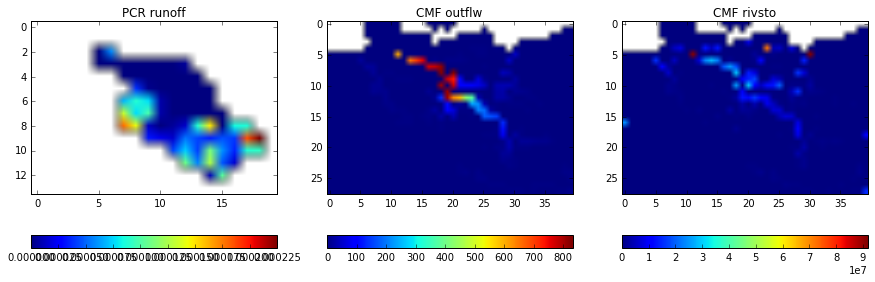

In [15]:
runoff = np.copy(PCR_bmi.get_var('landSurfaceRunoff'))
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = np.copy(CMF_bmi.get_var('rivsto_out'))
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [16]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-07 12:34:56.856127
end time coupling: 

NameError: name 'tEnd' is not defined

## Finalize models

In [17]:
PCR_bmi.finalize()
CMF_bmi.finalize()
DFM_bmi.finalize()


INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-07 17:12:53,144 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-07 17:12:53,146 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## Finalize models

4018 3233 4019 4018 4017
3233


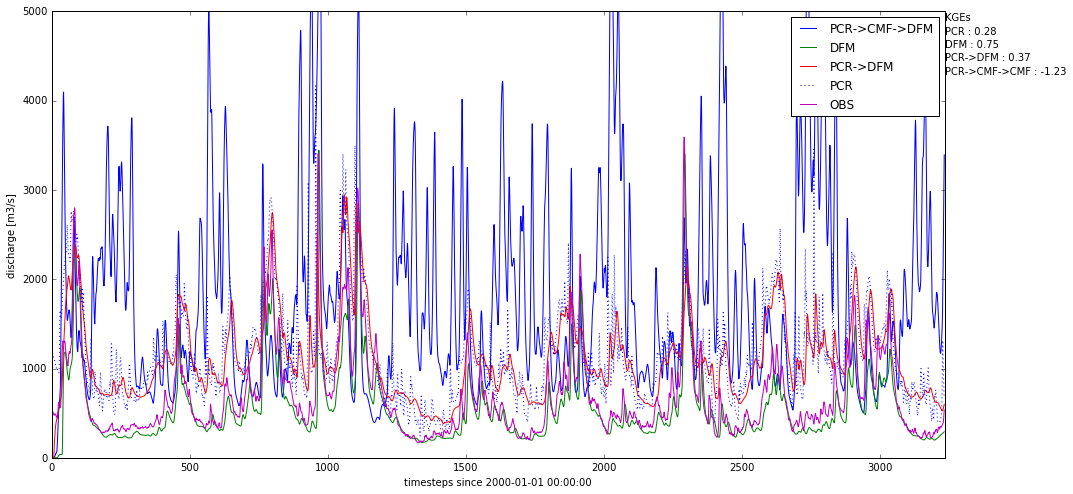

In [19]:
import matplotlib.dates as mdates
from netCDF4 import Dataset

#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
#- laod DFM output file (from 1way coupled PCR->DFM run)
fo_1way = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_1way_his.nc')
#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- load PCR file
po = os.path.join(cwd, 'test_Elbe/', 'Qsim_Elbe_Darchau_30min_2000s_industrial_prefactored.dump')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- estract PCR data
pd = np.loadtxt(po, unpack=True, skiprows=4)
PCR_ND = pd[1]
PCR_ND = PCR_ND[1:]

#- extract simulated discharge from nc-file (for this run)
no = Dataset(fo, 'r')
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

#- extract simulated discharge from nc-file for 1way PCR->DFM
no_1way = Dataset(fo_1way, 'r')
qsim_1way = no_1way.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_1way = np.absolute(qsim_1way[:,2])
qsim_ND_1way = np.absolute(qsim_1way[:,0])
qsim_downBC_1way = np.absolute(qsim_1way[:,1])

#- extract simulated discharge from nc-file for DFM standalone
no_stA = Dataset(fo_stA, 'r')
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

print len(qobs_ND), len(qsim_ND), len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND)
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND))
print minLength

if len(qobs_ND) > len(qsim_ND):
    qobs_ND = qobs_ND[:minLength]
    PCR_ND = PCR_ND[:minLength]
    qsim_ND_1way = qsim_ND_1way[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]

#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_1way = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_1way)
KGE_ND_1way = np.round(KGE_ND_1way,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)
KGE_ND_PCR = spotpy.objectivefunctions.kge(qobs_ND, PCR_ND)
KGE_ND_PCR = np.round(KGE_ND_PCR,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qsim_ND_1way, 'r', label = 'PCR->DFM')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(PCR_ND, ':',label = 'PCR')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4750, 'PCR : '+str(KGE_ND_PCR))
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4450, 'PCR->DFM : '+str(KGE_ND_1way))
plt.text(len(qsim_ND)+1,4300, 'PCR->CMF->CMF : '+str(KGE_ND))
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim.png'), dpi=300)

In [22]:
print spotpy.objectivefunctions.correlationcoefficient(qsim_ND_1way, qsim_ND)
print spotpy.objectivefunctions.correlationcoefficient(qsim_ND_1way, PCR_ND)
print spotpy.objectivefunctions.correlationcoefficient(qsim_ND, PCR_ND)

0.0298396149808
0.837156999808
0.00792902818899


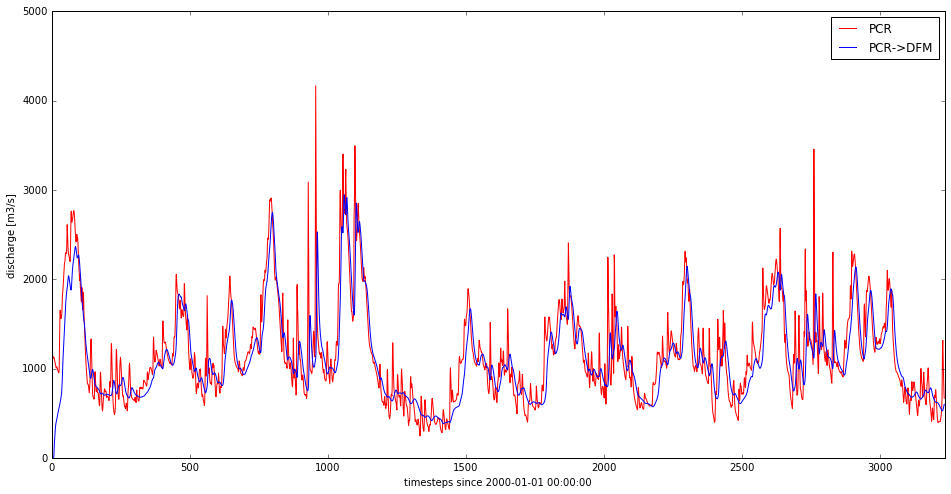

In [25]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

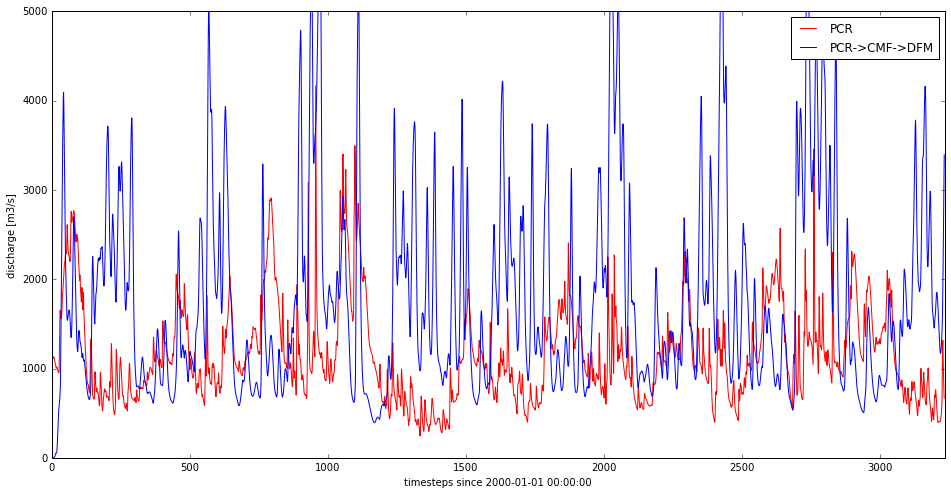

In [26]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

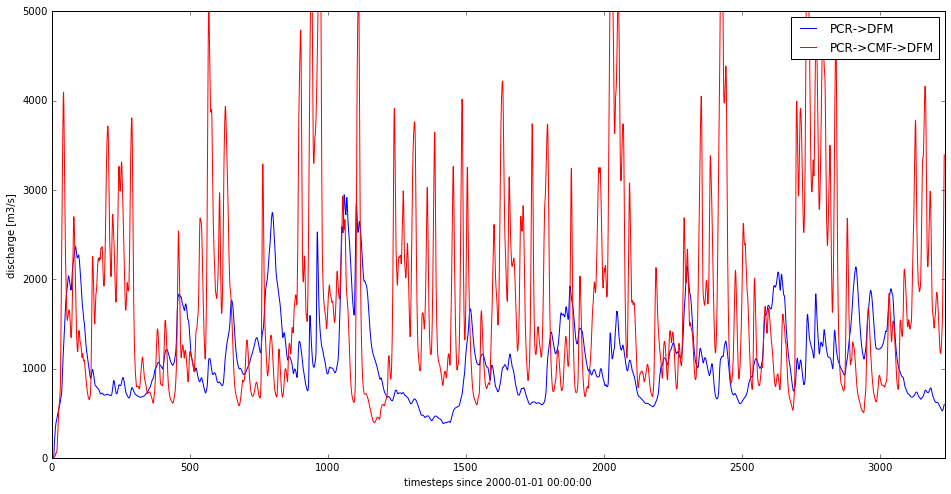

In [27]:
plt.figure(figsize=(16,8))
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.plot(qsim_ND, 'r', label = 'PCR->CMF->DFM')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))